In [ ]:
%load_ext autoreload
%autoreload 2


import os
import pymysql
import pandas as pd
from dotenv import load_dotenv, find_dotenv



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
env_path = find_dotenv()
load_dotenv(env_path)
#print(os.getenv('HOST'))
#print(os.getenv('USER_DB'))

True

In [ ]:
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')



## Easy features

-Resources added to queue

-Resources completed from queue

-Ratio of resources added to queue to completed

-Minutes learned per year



In [13]:
int(perplexity)

30

The first three is in the queue.py file. The last is in the time_learning.py

In [23]:
df_trk = pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_res = pd.read_sql_query("SELECT * FROM resource;", conn).drop_duplicates()

df_trk_copy=df_trk.copy()
df_res_copy=df_res.copy()
df_trk.to_csv('../raw_data/tracking_event.csv')
df_res.to_csv('../raw_data/resource.csv')

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [9]:
import numpy as np
# clean track_event

# reorder the dataframe according to the userID and eventDate
df_trk=pd.read_csv('../raw_data/tracking_event.csv')
#df_trk=df_trk_copy
df_trk.isna().sum()/len(df_trk) #content & skipMigration have over 80% missing values, delete these columns. And drop eventID
df_trk=df_trk.iloc[1:,:-2]
#df_trk['eventType'].apply(lambda)


# reorder 
df_trk=df_trk.sort_values(by=['userID','eventDate'],ascending=[True,True]).reset_index(drop=True)
df_trk
#-------------------------------------------------------------------------------------------

# return a dataframe with userID, eventType, source,eventDate, resourceType and action
# Get queueing status (returns 1 if completed from queue)
df_trk['resourceType']=df_trk['eventType'].apply(lambda x: x.split('_')[0])
df_trk['action']=df_trk['eventType'].apply(lambda x: x.split('_')[1])
df_trk.head(20)

# Get CompletionFromQueue (returns 1 if completed from the queue)


# Get mins learned per year(make this in a different py)



#Get resourceID and source
df_src=df_trk_copy[['resourceID','source']].drop_duplicates()
# create a dataframe with userID, numOfResourcesToQueue, numOfCompletionFromQueue, RatioOfCompletion_num, minOfResourcesToQueue, minOfCompletedFromQueue, RatioOfCompletion_min
# create "isQueued" columns, returns 1 if Queued
df_trk['isQueued']=df_trk['action'].map({'queued':1}).fillna(0).astype(int)
# create "isCompleted" columns, returns 1 if Completed
df_trk['isCompleted']=df_trk['action'].map({'completed':1, 'documented':1}).fillna(0).astype(int)

df_trk=df_trk.groupby(['userID','resourceID']).sum().reset_index()
# Get CompletionFromQueue (returns 1 if completed from the queue)
df_trk['CompletedFromQueue']=((df_trk['isQueued']==1)&(df_trk['isCompleted']==1)).astype(int)


df_trk=df_trk.merge(df_src,on='resourceID')


df_trk.head(20)

# add mins from the resourceID
df_res_select=df_res[['resourceID','min']].drop_duplicates()
df_trk=df_trk.merge(df_res_select,on='resourceID')
df_trk['minQueued']=df_trk['isQueued']*df_trk['min']
df_trk['minCompleted']=df_trk['CompletedFromQueue']*df_trk['min']


# if 'specified_source=True'
df_trk1=df_trk.groupby(['userID','source']).sum().reset_index()
df_trk1.rename(columns={'isQueued':'numQueued','CompletedFromQueue':'numCompletedFromQueue'},inplace=True)


df_trk1.head()

# if 'specified_source=False'
df_trk2=df_trk1.groupby(['userID']).sum().reset_index()
df_trk2['numQueued']=df_trk2['numQueued'].replace(0,-1)
df_trk2['minQueued']=df_trk2['minQueued'].replace(0,-1)
df_trk2['RatioOfCompletion_num']=np.abs(df_trk2['numCompletedFromQueue']/df_trk2['numQueued'])
df_trk2['RatioOfCompletion_min']=np.abs(df_trk2['minCompleted']/df_trk2['minQueued'])
# drop 'min' and 'isCompleted' as unnecessary
df_trk2=df_trk2.drop(['min','isCompleted'],axis=1)
#replace -1 back to 0
df_trk2['numQueued']=df_trk2['numQueued'].replace(-1,0)
df_trk2['minQueued']=df_trk2['minQueued'].replace(-1,0)
df_trk2.head(10)
#------------------------------------------------------------------

# if 'specified_source=True'
df_trk1['numQueued']=df_trk1['numQueued'].replace(0,-1)
df_trk1['minQueued']=df_trk1['minQueued'].replace(0,-1)
df_trk1['RatioOfCompletion_num']=np.abs(df_trk1['numCompletedFromQueue']/df_trk1['numQueued'])
df_trk1['RatioOfCompletion_min']=np.abs(df_trk1['minCompleted']/df_trk1['minQueued'])
#replace -1 back to 0
df_trk1['numQueued']=df_trk1['numQueued'].replace(-1,0)
df_trk1['minQueued']=df_trk1['minQueued'].replace(-1,0)
# drop min and 'isCompleted'
df_trk1=df_trk1.drop(['min','isCompleted'],axis=1)




In [70]:
import numpy as np
# # return a dataframe with userID, eventType, source,eventYear, resourceType and action

# clean track_event
# reorder the dataframe according to the userID and eventDate
df_trk=pd.read_csv('../raw_data/tracking_event.csv',index_col=[0])
#df_trk=df_trk_copy
df_trk.isna().sum()/len(df_trk) #content & skipMigration have over 80% missing values, delete these columns. And drop eventID
df_trk=df_trk.iloc[1:,:-2]
#df_trk['eventType'].apply(lambda)


# reorder 
df_trk=df_trk.sort_values(by=['userID','eventDate'],ascending=[True,True]).reset_index(drop=True)
df_trk['eventDate']=pd.to_datetime(df_trk['eventDate'])
df_trk['eventDate']=pd.DatetimeIndex(df_trk['eventDate']).year
df_trk.rename(columns={'eventDate': 'eventYear'},inplace=True)


# Get queueing status (returns 1 if completed from queue)
df_trk['resourceType']=df_trk['eventType'].apply(lambda x: x.split('_')[0])
df_trk['action']=df_trk['eventType'].apply(lambda x: x.split('_')[1])
df_trk.head(20)
df_trk.eventYear.unique()

# Get CompletionFromQueue (returns 1 if completed from the queue)


# Get mins learned per year(make this in a different py)



#Get resourceID and source
df_src=df_trk[['resourceID','source']].drop_duplicates()
# create a dataframe with userID, ResourcesToQueuePerYear_num, CompletionFromQueuePerYear_num, RatioOfCompletion_num, ResourcesToQueuePerYear_min, CompletedFromQueuePerYear_min, RatioOfCompletion_min
# create "isQueued" columns, returns 1 if Queued
df_trk['isQueued']=df_trk['action'].map({'queued':1}).fillna(0).astype(int)
# create "isCompleted" columns, returns 1 if Completed
df_trk['isCompleted']=df_trk['action'].map({'completed':1, 'documented':1}).fillna(0).astype(int)


# Get CompletionFromQueue (returns 1 if completed from the queue)
df_trk['CompletedFromQueue']=((df_trk['isQueued']==1)&(df_trk['isCompleted']==1)).astype(int)



df_trk=df_trk.drop_duplicates()

#df_trk.head(20)

# add mins from the resourceID
df_res_select=df_res[['resourceID','min']].drop_duplicates()
df_trk=df_trk.merge(df_res_select,on='resourceID')
df_trk['minQueued']=df_trk['isQueued']*df_trk['min']
df_trk['minCompletedFromQueue']=df_trk['CompletedFromQueue']*df_trk['min']
#df_trk['minCompleted']=df_trk['isCompleted']*df_trk['min']
df_trk.head(20)


#--------------------------------------------------------------------------------------






# if 'specified_source=False'
df_trk.rename(columns={'isQueued':'numQueued','CompletedFromQueue':'numCompletedFromQueue'},inplace=True)
df_trk2=df_trk.groupby(['userID','eventYear']).sum().reset_index()
df_trk2['numQueued']=df_trk2['numQueued'].replace(0,-1)
df_trk2['minQueued']=df_trk2['minQueued'].replace(0,-1)
df_trk2=df_trk2.groupby('userID').mean().reset_index()
df_trk2['RatioOfCompletion_num']=np.abs(df_trk2['numCompletedFromQueue']/df_trk2['numQueued'])
df_trk2['RatioOfCompletion_min']=np.abs(df_trk2['minCompletedFromQueue']/df_trk2['minQueued'])
# drop 'eventYear', 'min' and 'isCompleted' as unnecessary
df_trk2=df_trk2.drop(['min','isCompleted','eventYear'],axis=1)
#replace -1 back to 0
df_trk2['numQueued']=df_trk2['numQueued'].replace(-1,0)
df_trk2['minQueued']=df_trk2['minQueued'].replace(-1,0)
df_trk2.rename(columns={'numQueued':'numQueuedPerYear','minQueued':'minQueuedPerYear','numCompletedFromQueue':'numCompletedFromQueuePerYear','minCompletedFromQueue':'minCompletedFromQueuePerYear'},inplace=True)
df_trk2.head(10)




,userID,numQueuedPerYear,numCompletedFromQueuePerYear,minQueuedPerYear,minCompletedFromQueuePerYear,RatioOfCompletion_num,RatioOfCompletion_min
0,00001d9c-5de5-4ed2-9ecc-98341286765a,5.5,0.0,349.5,0.0,0.0,0.0
1,0000c854-c7a3-4047-9a54-2e1a3464621f,0.0,0.0,0.0,0.0,0.0,0.0
2,000169ca-f6bf-4ac0-a13d-c2b188014962,0.0,0.0,0.0,0.0,0.0,0.0
3,0001c897-b1fe-40e0-afef-6a667edf41f7,0.0,0.0,0.0,0.0,0.0,0.0
4,0002e8b5-261b-44a6-b38c-2997b4007317,0.0,0.0,0.0,0.0,0.0,0.0
5,0002f0ba-44b0-44d3-a542-3be3dd4d5036,0.0,0.0,24.5,0.0,NaN,0.0
6,00034f05-a97f-4dfe-8162-f83b7709b392,0.0,0.0,0.0,0.0,0.0,0.0
7,00036835-5926-476a-bd8a-65c39be4e6cc,69.0,0.0,2009.0,0.0,0.0,0.0
8,0003f9de-385c-45dc-9b19-31df24266aa9,0.0,0.0,0.0,0.0,0.0,0.0
9,00049633-8b5c-4a00-b869-4c107f941d13,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df_trk_copy[(df_trk_copy.userID=='00001d9c-5de5-4ed2-9ecc-98341286765a') & df_trk_copy.resourceID=='029cbba7-655e-4d67-a17f-80ba5beabb7a']

,eventID,userID,resourceID,eventType,source,eventDate,content,skipMigration


#### df_trk1.head(20)

## Easy Feature Min per year

Two potential resources:

-'activity_20220808' (use this)

-tracking_event

-

Two Steps:
1.create a column to get user's Ausmed year (from user AusmedYear=lastest activity date-account createDate)
2.caculate the total min

In [5]:
# check activity data
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()

df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()
df_act.to_csv(f'../raw_data/activity_2022080_{nrow}.csv')
df_usr

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [12]:
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

# drop duplicated events
df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['owner','providerName','min','updateDate','completeDate','activityType']
df_act=df_act[selected_columns]
#replace missing values of 'updateDate'
df_act['completeDate']=df_act['completeDate'].fillna(df_act['updateDate'])







df_act['providerName'].replace('N/A',None,inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')


#

# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
##################################################################################

# get yearsOnAusmed 
df_usr=df_usr_copy[['userID','createDate']]
df_usr=df_usr.merge(df_act, on='userID', how='inner')
df_usr['yearsOnAusmed']=df_usr['completeDate']-df_usr['createDate']
df_usr=df_usr.groupby('userID').max().reset_index()
df_usr.head()

#####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType,minPerYear,percentageLearningFromAusmed
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType


def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls

# If a user has multiple favActivityType, randomly select one
def fav_fav(series):
    mode=series.mode()
    if len(mode)==1:
        return mode
    else:
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]



# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act['isAusmed']=df_act['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act['minOnAusmed']=df_act['min']*df_act['isAusmed']


# Get user's favorite and 2nd favorite activityType
# first create a copy of acticityType to get 2nd favorite activityType
df_act['2ndFavActivityType']=df_act['activityType']
df_act=df_act.groupby('userID').agg({'min': sum, 'minOnAusmed': sum, 'activityType': fav_fav, '2ndFavActivityType': fav_activityType}).reset_index()


# merge with df_usr
df_act1=df_act # save a copy
df_act=df_usr[['userID','yearsOnAusmed']].merge(df_act, on='userID', how='inner')


# rename the columns
df_act.rename(columns={'activityType': 'favActivityType'},inplace=True)





# get Min learnt from Ausmed
df_act['yearsOnAusmed']=df_act['yearsOnAusmed']/ np.timedelta64(1, 'Y')
df_act['minOnAusmedPerYear']=df_act['minOnAusmed']/df_act['yearsOnAusmed']

# get percentageOfLearningFromAusmed
df_act['minPerYear']=df_act['min']/df_act['yearsOnAusmed']
df_act['percentageOfLearningFromAusmed']=df_act['minOnAusmedPerYear']/df_act['minPerYear']

# drop uneeded columns
df_act=df_act.drop(columns=['yearsOnAusmed','min','minOnAusmedPerYear'])

# drop na
df_act=df_act.dropna()

# 


In [168]:
import numpy as np
import seaborn as sns
#df_act[df_act['providerName']=='N/A']

#df_act['favActivityType'].value_counts()
df_act['minPerYear'].plot.density()

NameError: name 'df_act' is not defined

# Easy feature: numDocumentationPerYear

In [32]:
# load the data
# check activity data
nrow=2000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()


df_act_copy=df_act.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [35]:
df_act.status.unique()

array(['Completed', 'Done', 'Unevaluated'], dtype=object)

In [93]:
df_act.isna().sum()/len(df_act) #
# create a dataFrame with numOfDocumentationPerYear, 
import random
import datetime as dt

# clean data here
# create a data frame with 'userID', 'activityType', 'providerName', 
df_act=df_act_copy
df_act['providerName'].unique()
#df_act['status'].unique()

#sort by 'userID' the 'min'
df_act=df_act.sort_values(by=['owner','min'],ascending=[True,True])
# drop duplicated events

df_act=df_act.drop_duplicates(subset=['activityID','owner','resource','min'],keep='last')

# create minPerYear
## step1: get total min
selected_columns=['activityID','owner','providerName','min','createDate','activityType']
df_act=df_act[selected_columns]

# get Years of the activities
df_act['createDate']=pd.to_datetime(df_act['createDate'])
df_act['createDate']=pd.DatetimeIndex(df_act['createDate']).year




df_act['providerName'].replace('N/A','Unknown',inplace=True)
df_act['providerName'].replace('','Unknown',inplace=True)
# see if can get missing values from tracking event!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! DO THIS!!!!!!!!!!!!!!!!!!!!!!!!!!

# fill in missing value with 'Unknown'
df_act['providerName']=df_act['providerName'].fillna('Unknown')




# rename 'owner' as 'userID'
df_act.rename(columns={'owner':'userID'},inplace=True)
df_act.head(20)
df_act_cleaned=df_act.copy()
# ##################################################################################



# #####################################################################################
# get features here
# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType, minPerYear, docPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
# create two columns to get favoriteActivityType, 2ndfavoriteActivityType
#define a function to get the nth/2nd most frequent activityType
df_act1=df_act

def fav_activityType(series,n=2):
    ls=series.value_counts().index.tolist()[:n-1]
    return ls[0]

# If a user has multiple favActivityType, randomly select one
def fav_fav(series):
    mode=series.mode()
    if len(mode)==1:
        return mode
    else:
        #print(mode)
        ind=random.randint(0,len(mode)-1)
        return mode[ind]



# create a column "isAusmed": returns 1 if the provider is Ausmend
df_act1['isAusmed']=df_act1['providerName'].apply(lambda x: 1 if ('Ausmed' in x) else 0 )
df_act1['minOnAusmed']=df_act1['min']*df_act['isAusmed']

df_act1.head(20)

# create a column for the number of documetation
df_act1['numOfDoc']=1

df_act1=df_act1.groupby(['userID','createDate']).agg({'numOfDoc': sum,'isAusmed':sum, 'min': sum, 'minOnAusmed': sum}).reset_index()




# rename the columns
df_act1.rename(columns={ 'createDate': 'createYear','isAusmed':'numOnAusmed'},inplace=True)
df_act1.sort_values('userID',inplace=True)

df_act1.head()
df_act1_copy=df_act1.copy()
##################################################################################################

# get the docPerYear and minPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
df_act2=df_act1_copy
df_act2=df_act2.groupby('userID').mean().reset_index()
# rename the data frame
df_act2.rename(columns={'numOfDoc':'docPerYear','numOnAusmed':'docOnAusmedPerYear','min':'minPerYear','minOnAusmed':'minOnAusmedPerYear'},inplace=True)

# drop 'createYear'
df_act2.drop(columns=['createYear'],inplace=True)

# get ratios
df_act2['learnFromAusmedRatio_num']=df_act2['docOnAusmedPerYear']/df_act2['docPerYear']
df_act2['learnFromAusmedRatio_min']=df_act2['minOnAusmedPerYear']/df_act2['minPerYear']
df_act2.head(20)

df_act2_copy=df_act2.copy()


####################################################################################################

# get the favoriteActivityType, 2ndfavoriteActivityType of users
# returns a data frame with userID,favActivityType, secondfavActivityType
df_act3=df_act_cleaned

# create a replica of the activityType to get the secondFavActivityType
df_act3['secondFavActivityType']=df_act3['activityType']
df_act3=df_act3.groupby(['userID']).agg({'activityType': fav_fav, 'secondFavActivityType': fav_activityType}).reset_index()
df_act3

df_act3_copy=df_act3.copy()



#####################################################################################################

# returns a data frame with userID,favoriteActivityType, 2ndfavoriteActivityType, minPerYear, docPerYear, learnFromAusmedRatio_min, learnFromAusmedRatio_num
# merge docPerYear dataframe and favActivityType dataframe together
df_act2=df_act2_copy
df_act3=df_act3_copy

df_act4=df_act3.merge(df_act2,on='userID',how='inner')

df_act4=df_act4.dropna()
df_act4.docPerYear.value_counts()

# df_act.head(20)

1.0    1955
2.0       8
1.5       1
Name: docPerYear, dtype: int64

In [42]:
df_act[['createDate']].year

AttributeError: 'DataFrame' object has no attribute 'year'

# Get true users

# Hidden features

## Task1: % of users compliant per year (consdier hours of CPD completed and documented, learning goals set, context of practice set)

-CPD requirement is in the "groupRegulation"

-Goal: replacing intented 

-Q: how do we define overachiver/ casual learner/ ambitious learner

In [104]:
# clean context of practice set

#create a table return CPD record with CPD hours required, CPD completed, documented

#create a goal table with column, goals per year, number of goals achived, ratio of goals achieved, ratio of 

# make compliency() function returns 

In [109]:
# clean context of practice set
#load the data
df_cop = pd.read_sql_query("SELECT * FROM contextOfPractice;", conn)
df_pp=pd.read_sql_query("SELECT * FROM professionalprofile;", conn).drop_duplicates()
df_wk=pd.read_sql_query("SELECT * FROM work;", conn).drop_duplicates()
df_edu=pd.read_sql_query("SELECT * FROM education;", conn).drop_duplicates()
df_usr=pd.read_sql_query("SELECT * FROM user;", conn).drop_duplicates()



df_cop_copy=df_cop.copy()
df_pp_copy=df_pp.copy()
df_wk_copy=df_wk.copy()
df_edu_copy=df_edu.copy()
df_usr_copy=df_usr.copy()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versio

In [103]:
# create a column to identify if the user has record in contextOFpractice
print(f'the number of users with cop record is {df_cop.pProfile.nunique()}')
df_cop.nunique()


the number of users with cop record is 54025


contextID         82868
pProfile          54025
typeOfPractice     3525
located               7
specialities      34289
population         4774
focus              3966
complex              11
autonomy              6
access                4
startDate          5858
endDate             643
createDate        82772
updateDate        82778
topics              349
summary           13038
dtype: int64

In [114]:
# investigate the duplicated
df_cop[df_cop.duplicated(subset=['pProfile'],keep=False)].sort_values(by='pProfile')

#

,contextID,pProfile,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,endDate,createDate,updateDate,topics,summary
38995,77efd74a-8b75-4c4c-a246-da261ba61e2b,00004d77-37dd-418f-a3d4-7d55ab19bdec,Pre-hospital emergency care,large rural centre,Emergency critical care,adults,Clinical,high complexity,high,usually,2018-12-01,2019-11-30,2019-11-04 19:18:38,2019-11-04 19:18:38,None,None
17006,34044648-b94a-416f-8a17-81ec235b7eee,00004d77-37dd-418f-a3d4-7d55ab19bdec,community,large rural centre,"Pre-hospital emergency care,Aeromedical retrieval",adults,clinical practice,high complexity,high,usually,2019-12-01,2020-11-30,2020-11-07 14:24:24,2020-11-07 14:24:24,None,None
38964,77d58a45-2315-4768-a34f-8ef23271739e,0000f618-87c9-4a0d-ae9e-86211801b59a,prehospital care,capital city,Pre hospital care,The whole community,clinical practice,high complexity,high,always,2004-09-06,None,2021-07-12 10:37:12,2021-07-12 10:37:12,None,None
17090,34513fa0-a2b4-4322-8cf2-5218d4e41e9b,0000f618-87c9-4a0d-ae9e-86211801b59a,community,capital city,Pre hospital care,The whole of the community,clinical practice,high complexity,high,always,2004-01-01,None,2021-07-12 10:40:50,2021-07-12 10:40:50,None,None
40331,7be611cd-f049-4819-909a-d06f4f045224,0002323f-296f-4357-9871-66f0b6370a16,hospital,metropolitan centre,"Acute care - Orthopaedic and General Surgery,S...",adults,clinical practice,generally complex,moderate,sometimes,2017-06-01,2018-05-31,2017-03-30 16:36:34,2018-04-29 04:59:56,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34979,6b7dae56-b99c-43fd-bad6-8f410afe36c1,fff0b784-23bb-422f-972e-0124af398098,hospital,small rural centre,Acute,adults,clinical practice,generally complex,moderate,usually,2016-06-01,2017-05-31,2017-03-30 22:33:31,2017-03-30 22:33:31,None,None
76884,ed21dceb-c88d-4563-869e-f6958d9d6f19,fff72ee2-ba36-49a0-a750-844bbbe0e0b1,hospital,capital city,"Paediatric ,paediatric",children,management,very complex,moderate,always,2020-06-01,None,2021-07-18 11:26:36,2021-07-18 11:26:36,None,I work in a hospital setting located in a capi...
38384,760cba5b-f380-44c2-9ac5-8593de1d1bc1,fff72ee2-ba36-49a0-a750-844bbbe0e0b1,hospital,metropolitan centre,Paediatrics,children,management,very complex,moderate,always,2019-06-01,2020-05-31,2020-03-03 01:07:46,2020-03-03 01:07:46,None,None
20105,3da47e33-34f0-4f5b-b247-f6c52bfa31e0,fff7a64d-7c36-4295-a957-77b5dde7ddb8,hospital,metropolitan centre,DOSA,adults,clinical practice,generally complex,moderate,always,1981-07-02,None,2020-09-14 18:21:25,2020-09-14 18:21:25,None,None


In [116]:
df_pp.info()
df_pp.nunique() # good no duplicates

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302833 entries, 0 to 302832
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   pProfileID               302833 non-null  object
 1   owner                    302833 non-null  object
 2   regulatedQualifications  336 non-null     object
 3   startDate                0 non-null       object
 4   endDate                  0 non-null       object
 5   country                  302833 non-null  object
 6   state                    15880 non-null   object
 7   board                    302822 non-null  object
 8   timezone                 1615 non-null    object
 9   otherProfession          30810 non-null   object
dtypes: object(10)
memory usage: 25.4+ MB


pProfileID                 302833
owner                      301103
regulatedQualifications        18
startDate                       0
endDate                         0
country                       192
state                          61
board                          64
timezone                        1
otherProfession              4974
dtype: int64

In [149]:
# main
# This table has one-to-many relationships, keep the lastest 
# return userID,typeOfPractice, located	specialities, population, focus, complex autonomy access startDate, yearsOfExperience
df_cop = df_cop_copy
df_pp=df_pp_copy




df_cop=df_cop[['pProfile', 'typeOfPractice', 'located', 'specialities',
       'population', 'focus', 'complex', 'autonomy', 'access','startDate','createDate','endDate']]

# df_cop.iloc[[3575]]['startDate'] is '-2019-12-09' must have been typo, let's change that!
df_cop.at[3575,'startDate']='2019-12-09'

# link with userID
df_pp_select=df_pp[['pProfileID', 'owner','country']].drop_duplicates()
df_pp_select.head()
merged_df=df_cop.merge(df_pp_select,left_on='pProfile',right_on='pProfileID',how='right')\
.drop_duplicates().rename(columns={'owner':'userID'})# rename 'owner' as 'userID'


#merged_df[merged_df.duplicated(subset=['userID'],keep=False)]



# create a column if the user has record in contextOfPractice
merged_df['pProfile'].fillna(0,inplace=True)
merged_df['hasPracticeRecord']=merged_df['pProfile'].apply(lambda x: 1 if x!=0 else 0)
# merged_df_copy=merged_df
# # here return a data frame with 'userID' and 'hasPracticeRecord'
# df_cop1=merged_df_copy[['userID','hasPracticeRecord']].drop_duplicates()
# df_cop1=df_cop1.groupby('userID').max().reset_index()


# some users have multiple profileID use the lastest pro profile, preferably with record
merged_df=merged_df_copy
merged_df.sort_values(by=['userID','hasPracticeRecord','startDate'],ascending=[True,False,False],inplace=True)
merged_df=merged_df.drop_duplicates(subset=['userID'],keep='first')


# drop 'pProfileID' as redundant, move usersID and pProfileID to the front
merged_df=merged_df.drop(['pProfileID'],axis=1)
cols = list(merged_df)
# move the column to head of list using index, pop and insert
#cols.insert(0, cols.pop(cols.index('pProfileID')))
cols.insert(0, cols.pop(cols.index('userID')))


# merged_df = merged_df.loc[:, cols].drop_duplicates().sort_values(by=['userID','startDate'],ascending=[True,False])

# # only keep the lastest
# merged_df.drop_duplicates(subset=['userID'],keep='first',ignore_index=True,inplace=True)
# #merged_df.head(10)

# drop "startDate, createDate, endDate" as they are no longer needed, drop the 'hasPracticeRecord' as this is not accurate, will merge with 
merged_df.drop(['startDate', 'createDate', 'endDate'],axis=1,inplace=True)

merged_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301103 entries, 129135 to 221815
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   pProfile        301103 non-null  object
 1   typeOfPractice  54010 non-null   object
 2   located         54010 non-null   object
 3   specialities    54010 non-null   object
 4   population      54010 non-null   object
 5   focus           54010 non-null   object
 6   complex         54010 non-null   object
 7   autonomy        54010 non-null   object
 8   access          54010 non-null   object
 9   userID          301103 non-null  object
 10  country         301103 non-null  object
dtypes: object(11)
memory usage: 27.6+ MB


In [145]:
df_cop1.nunique()
merged_df

,pProfile,typeOfPractice,located,specialities,population,focus,complex,autonomy,access,startDate,createDate,endDate,pProfileID,userID,country,hasPracticeRecord
129135,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,63baee89-cc77-4753-8dae-b495e263fe9f,00001d9c-5de5-4ed2-9ecc-98341286765a,AUS,0
92298,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,4752b57c-2c61-4117-87c1-c099be3642a9,00001fb9-98c7-4dd4-b922-40a4094cd0d8,AUS,0
136315,694b3b93-e762-427b-a1b8-72426d764a6c,private company,metropolitan centre,Perioperative Nursing,adults,clinical practice,generally complex,moderate,usually,2020-07-15,2020-07-14 21:46:21,None,694b3b93-e762-427b-a1b8-72426d764a6c,0000c854-c7a3-4047-9a54-2e1a3464621f,AUS,1
15429,0bbfbfc8-5b48-4ca1-b05f-21638761d716,private practice,metropolitan centre,"General Practice,Immunisation",adults,clinical practice,generally complex,moderate,always,2014-06-01,2017-08-09 01:33:41,2015-05-31,0bbfbfc8-5b48-4ca1-b05f-21638761d716,00013cfc-f97f-428d-bf6b-558601512bd7,AUS,1
135848,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,68eb058c-22ab-4b45-8f78-6d65e309aaa8,000161bd-3737-49f4-9733-b1fd7577647c,AUS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272088,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,d2074d69-aa6c-42e4-b8e3-1898634030d7,ffff1bc4-d54f-4c43-926c-0146f22dd26f,AUS,0
94259,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,48d01593-0bbb-44c8-b2b7-1989f7ffa87d,ffff531f-a530-49e8-8667-88490d19845b,AUS,0
137673,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,6a5527ef-1d8f-4a6c-b9a1-c7da3c3a16b4,ffff5a90-d347-47d3-ac12-3bec59c19512,AUS,0
167051,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,80dd710c-bb1b-477a-96ca-0d5b55827e59,ffffca0f-a10f-466e-8179-f91c11035d15,AUS,0


# Hidden Feature 

## Task 2: learning goals set

- learning goals set

- Goals set per year:

-- step 1: convert 'startDate' to year

-- step2: group userID then 'StartDate' in year

- Ratio of achived goals per year

- create a columns to isOverAchiever

- NLP on 'title', join all titles together (NLP during the final preprocessing)

In [4]:
# download relevent data
df_goal=pd.read_sql_query("SELECT * FROM goal;", conn).drop_duplicates()
df_gcs=pd.read_sql_query("SELECT * FROM goalCompetencyStandard;", conn).drop_duplicates()
df_grr=pd.read_sql_query("SELECT * FROM groupRegulation;", conn).drop_duplicates()
#rename owner to userID
df_goal.rename(columns={'owner': 'userID'},inplace=True)

df_goal_copy=df_goal.copy()
df_gcs_copy=df_gcs.copy()
df_grr_copy=df_grr.copy()


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [27]:
df_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122586 entries, 0 to 122585
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   goalID              122586 non-null  object        
 1   owner               122586 non-null  object        
 2   title               122586 non-null  object        
 3   startDate           122424 non-null  datetime64[ns]
 4   endDate             117569 non-null  datetime64[ns]
 5   startDateLocal      99468 non-null   object        
 6   endDateLocal        99468 non-null   object        
 7   topics              8216 non-null    object        
 8   priority            116228 non-null  float64       
 9   isAchieved          122586 non-null  int64         
 10  publicGoal          0 non-null       object        
 11  qualifications      8847 non-null    object        
 12  intendedMin         7911 non-null    float64       
 13  completedMin        122489 no

In [44]:
import datetime as dt
# get average goals per 
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
df_goal['createYear']=pd.DatetimeIndex(df_goal['createDate']).year



df_goal=df_goal.groupby(['userID','createYear']).count().reset_index()

# get average goals per year
df_goal=df_goal[['userID','createYear','goalID']]
df_goal.rename(columns={'goalID': 'GoalsPerYear'},inplace=True)
df_goal=df_goal.groupby('userID').mean().reset_index()

# drop 'createYear'
df_goal.drop(columns=['createYear'],inplace=True )

df_goal

,userID,GoalsPerYear
0,00013cfc-f97f-428d-bf6b-558601512bd7,4.00
1,00023498-c236-45f6-aaf1-ee382e520737,6.00
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,2.75
3,00036835-5926-476a-bd8a-65c39be4e6cc,4.00
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,3.00
...,...,...
44763,fff95fa2-b077-4d86-9f53-e55976b01fa8,1.00
44764,fff97381-13d4-4622-ab51-67d69ccfde75,2.00
44765,fff9d181-6644-4112-b85e-30c649506f7a,1.00
44766,fffd42d4-0db4-467e-977d-7d826fdd7d8c,1.00


In [58]:
# Get ratio of compeleted goals
# retures a dataframe with all 'userID', 'ratioOfAchivedGoal'
df_goal=df_goal_copy


df_goal=df_goal.groupby('userID').agg({'goalID':'count', 'isAchieved': 'sum'}).reset_index()

df_goal['ratioOfAchivedGoals']=df_goal['isAchieved']/df_goal['goalID']
df_goal.rename(columns={'goalID': 'numOfGoals'},inplace=True)
# drop 'isAchieved' and 'numOfGoals' columns

df_goal.drop(columns=['numOfGoals','isAchieved'],inplace=True)

df_goal

,userID,ratioOfAchivedGoals
0,00013cfc-f97f-428d-bf6b-558601512bd7,0.000000
1,00023498-c236-45f6-aaf1-ee382e520737,0.000000
2,0002f0ba-44b0-44d3-a542-3be3dd4d5036,0.090909
3,00036835-5926-476a-bd8a-65c39be4e6cc,0.250000
4,00049f68-a2a2-4d3d-bef6-f15c8c33a9dc,0.000000


In [8]:
# get title
# join all goal titles together 
df_goal=df_goal_copy
df_goal['metaGoalTitle']=df_goal.groupby('userID')[['title']].transform(lambda x: ' '.join(x))
df_goal[['userID','metaGoalTitle']].drop_duplicates()

,userID,metaGoalTitle
0,e970fb89-6e51-4da5-a578-45c64e3c04fd,Everything
1,9629fc28-f907-4273-9a70-46777969bdb8,To settle into working for a new organisation ...
2,567120d7-eee6-4a3b-87f8-aaaa38f8b4e4,4 year old healthy kids check Managing paediat...
3,5ec5104d-513b-4cfb-9a7b-fd62bd74d2dd,Complete mandatory training\nImprove my triage...
4,0f88ad4e-35fe-4f2f-a237-f292dd805d16,"By the end of the CPD year, I will update and ..."
...,...,...
122560,ed39da52-b261-447d-8846-aa6899b61547,Maintaining currency with Paramedical practice...
122568,27c98ed3-fccf-482b-9523-6cd40eb40830,By the end of the CPD year I would like to hav...
122571,1ba2838e-cf34-4bc5-84a9-d4a01550fac6,I always want to practice with the most releva...
122572,8abc7348-9e10-4972-92b1-8c61b4b16cd3,I want to do at least 2 hrs of CPD per month b...


In [9]:
df_goal['userID'].nunique()# good

44768

<AxesSubplot:xlabel='createDate', ylabel='Count'>

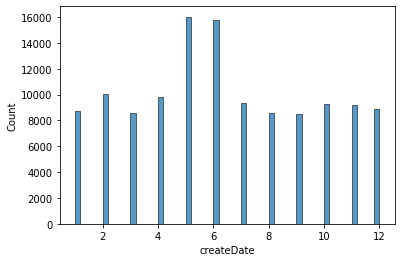

In [34]:
# see which month over the years has the most goals set
import seaborn as sns
df_goal=df_goal_copy
df_goal['createDate']=pd.to_datetime(df_goal['createDate'])
sns.histplot(pd.DatetimeIndex(df_goal['createDate']).month)

# Baseline Model

Let's pipe line up!

Preprocessing: 

- all numerical features: simimputer(median, because we have oustanding outliers) then Robustscaler for all numerical columns

- nice catogorical features: simpleinputer(mostfrequent) then OHE

- MiniBatichKmeans: play around with the number of clusters



In [ ]:
from customerclustering.db_connection import Db
from customerclustering.get_training_data import *

In [ ]:
import time
start_time = time.time()
# access to the data
conn = pymysql.connect(
    host=os.getenv('HOST'),
    port=int(3306),
    user=os.getenv('USER_DB'),
    passwd=os.getenv('PASSWORD_DB'),
    db=os.getenv('DB'),
    charset='utf8mb4')




rows=200000
df0=GetTrainingData(conn,rows).get_training_data()
df_copy=df0.copy()
print("--- %s seconds ---" % (time.time() - start_time))
df0.head()

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


Getting activity features


In [114]:
# save the file and check
df0.to_csv("../raw_data/training_data.csv")
df1=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df1.head()

,Product,Status,userID,stripeCustID,num_subs,account_age,pProfileID,typeOfPractice,located,specialities,...,minQueuedPerYear,minCompletedFromQueuePerYear,event_cpd_day_diff,doc_in_activation,activated,plan_type,subscribe_days,GoalsPerYear,ratioOfAchivedGoals,metaGoalTitle
0,Ausmed Subscription,incomplete_expired,6037d38d-d098-4f68-be8c-49b7131b8116,cus_CVloz8uJiXpqfF,10,1624.0,41b3e81d-ccdd-40c8-b268-874344b0a1bf,hospital,remote area,"Rehabilitation,Aged care ,Medical",...,88.4,0.0,117.197044,10,1,quarterly,1560,5.0,0.4,"To gain confidence ,skills and knowledge as a ..."
1,Ausmed Subscription,canceled,62d1fe96-34f6-4992-9f15-b240f07770d8,cus_EoCO9ITZcMHmkA,9,1244.0,71a06b47-4762-49d2-b5fd-161c7ce6e1cd,hospital,large rural centre,Addiction and Substance Abuse,...,114.0,0.0,164.064103,2,1,quarterly,0,1.5,0.0,Do my best Gehenna d f r dwa wa daw daw
2,Ausmed Subscription,canceled,6e6b0e01-4a29-4724-a781-5d6a0d72a213,cus_BVqWWYIZ4tLhQr,6,2133.0,0cccdf89-bae9-4d06-8a40-81a6c7b3b7ce,GP Surgery,metropolitan centre,"Immunisation,Chronic Illness",...,98.4,0.0,149.362205,4,1,monthly,193,2.0,0.0,Covid vaccination and wound management. \nMy r...
3,Ausmed Subscription,active,33d2881f-8bc6-4b98-bafe-bfd20b141ee2,cus_AVUDPqhuPS9HRy,5,1956.0,72593341-edad-404e-9a92-bf7f576e5207,hospital,metropolitan centre,aged care; wound care and the continuity of he...,...,381.8,0.0,76.311787,2,1,quarterly,326,1.0,0.0,By the end of 2021 I would like to expand my k...
4,Ausmed Subscription,incomplete_expired,5f048ee3-4ea0-41e1-b859-c1cd9c95d80b,cus_F71ikWaGTyumEe,5,1194.0,752db353-5793-4636-acd7-fe3205291c91,Unemployed.,small rural centre,NaN,...,628.0,0.0,8.618321,4,1,quarterly,84,2.0,0.0,"Study, learn and retain knowledge. Do online s..."


In [115]:
df1.columns

Index(['Product', 'Status', 'userID', 'stripeCustID', 'num_subs',
       'account_age', 'pProfileID', 'typeOfPractice', 'located',
       'specialities', 'population', 'focus', 'complex', 'autonomy', 'access',
       'country', 'hasPracticeRecord', 'docPerYear', 'docOnAusmedPerYear',
       'minPerYear', 'minOnAusmedPerYear', 'learnFromAusmedRatio_num',
       'learnFromAusmedRatio_min', 'activityType', 'secondFavActivityType',
       'numQueuedPerYear', 'numCompletedOnelinePerYear',
       'numCompletedFromQueuePerYear', 'minCompletedOnelinePerYear',
       'minQueuedPerYear', 'minCompletedFromQueuePerYear',
       'event_cpd_day_diff', 'doc_in_activation', 'activated', 'plan_type',
       'subscribe_days', 'GoalsPerYear', 'ratioOfAchivedGoals',
       'metaGoalTitle'],
      dtype='object')

In [109]:
df1.isna().sum()/len(df1)

Product                     0.000000
Status                      0.000000
userID                      0.000000
stripeCustID                0.000000
num_subs                    0.000000
account_age                 0.098503
pProfileID                  0.000000
typeOfPractice              0.099171
located                     0.099038
specialities                0.099840
population                  0.099439
focus                       0.099439
complex                     0.099038
autonomy                    0.099038
access                      0.099038
country                     0.000000
hasPracticeRecord           0.000000
docPerYear                  0.000000
docOnAusmedPerYear          0.000000
minPerYear                  0.000000
minOnAusmedPerYear          0.000000
learnFromAusmedRatio_num    0.000000
learnFromAusmedRatio_min    0.000000
activityType                0.000000
secondFavActivityType       0.000000
eventYear                   0.000000
isQueued                    0.000000
i

In [2]:
#base pipeline
import pandas as pd
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer


# reindex df
df=pd.read_csv('../raw_data/training_data.csv')
df=df.set_index('userID')

# drop 'pProfileID' and 'stripeCustID' and Date columns
df.drop(columns=['pProfileID','stripeCustID'],inplace=True)

# select columns
# use all numerical columns
num_col=df.describe().columns
#do not include meta_title
cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle') & (df[col].nunique()<5)]

# Robustscaler all numerical columns
num_transformer=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())


preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_col),remainder='drop')
#preproc.fit_transform(df)
preproc


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  Index(['Unnamed: 0', 'num_subs', 'account_age', 'hasPracticeRecord',
       'docPerYear', 'docOnAusmedPerYear', 'minPerYear', 'minOnAusmedPerYear',
       'learnFromAusmedRatio_num', 'learnF...
       'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'subscribe_days', 'GoalsPerYear',
       'ratioOfAchivedGoals'],
      dtype='object')),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['access', 'plan_type'])]))])

In [ ]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer

# reindex df
df=pd.read_csv('../raw_data/training_data.csv')
#df=df.set_index('userID')



# # drop all nan
# df=df.dropna()
# # drop 'pProfileID' and 'stripeCustID' and Date columns
# df.drop(columns=['pProfileID','stripeCustID'],inplace=True)

# # select columns
# # use all numerical columns
# num_col=df.describe().columns
# #do not include meta_title
# cat_col=[col for col in df.columns if (col not in num_col)&(col!='metaGoalTitle')& (df[col].nunique()<5)]
# print(cat_col)

# # Robustscaler all numerical columns
# num_transformer=RobustScaler()

# #LabelEncoder all categorical columns
# cat_transformer=LabelEncoder()


# # Our first base pipeline-doesn't work
# preproc=make_column_transformer((num_transformer,num_col))#,(cat_transformer,cat_col))



# # # manually transform the numerical and categorical columns
# # ## numerical
# # df_num=pd.DataFrame(num_transformer.fit_transform(df[num_col]))
# # df_num.columns=num_col
# # df_num.head()

# # ## categorical
# # df_cat=df[cat_col].apply(cat_transformer.fit_transform)

# # df_processed=df_num
# # df_processed[cat_col]=df_cat
# # df_processed.head()

# # # reindex df by userID
# # df_processed.set_index(df['userID'],inplace=True)
# # df_processed

# # basepipe=make_pipeline(preproc,MiniBatchKMeans()) #shame on you!

# # basepipe

### Use Elbow Method to find the optimal cluster size

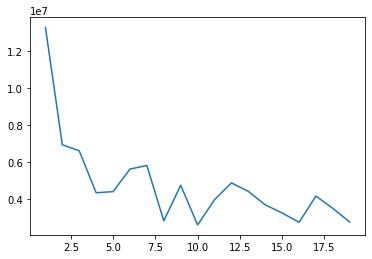

In [35]:
import matplotlib.pyplot as plt
# find the optimal n_cluster
df_processed=preproc.fit_transform(df)
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(pf_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss)

Looks like the optimal number of cluster is around 14, but should we go that far? Maybe 8 is enough?

# Visualization of the Basemodel Output

In [36]:
# The baseline model
print(f"The optimal cluster size is {clusters[wcss.index(min(wcss))]}") # this gives 14

base_model=MiniBatchKMeans(n_clusters=16)
X_pred=base_model.fit(df_processed).predict(df_processed)


The optimal cluster size is 10


In [38]:
# get centers
df_centers=pd.DataFrame(base_model.cluster_centers_)
#df_centers.columns=df_processed.columns
df_des=df_centers.describe()
df_des


,0,1,2,3,4,5,6,7,8,9,...,27588,27589,27590,27591,27592,27593,27594,27595,27596,27597
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,...,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,0.142905,-0.051962,-0.137625,0.411842,-0.037820,2.591889,0.529975,0.053590,0.069837,0.876676,...,0.000209,0.008852,0.004151,0.001403,0.009948,0.240826,0.440374,0.106097,0.237322,0.656581
std,0.056984,0.122127,0.117713,0.328610,0.327617,6.731216,0.483875,0.166538,0.210139,0.919903,...,0.000600,0.025086,0.004238,0.005069,0.009677,0.085258,0.109108,0.034645,0.090954,0.090763
min,0.038136,-0.361797,-0.476064,-0.079227,-0.657161,-0.112497,-0.082194,-0.313984,-0.378090,-0.131982,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.033898,0.233503,0.050926,0.107968,0.507614
25%,0.107195,-0.101649,-0.116273,0.226784,-0.198346,0.379321,0.263764,-0.075640,-0.077565,0.216720,...,0.000000,0.000000,0.000000,0.000000,0.001415,0.194772,0.381352,0.087300,0.172795,0.600170
50%,0.160053,-0.028811,-0.096173,0.343511,0.008192,0.500963,0.486139,0.110920,0.151067,0.841428,...,0.000000,0.000435,0.004374,0.000000,0.007990,0.259179,0.460334,0.103447,0.230261,0.656973
75%,0.177584,0.042548,-0.085147,0.522881,0.095707,1.173000,0.585410,0.169621,0.217820,1.187507,...,0.000000,0.003465,0.005402,0.000000,0.014385,0.314693,0.487005,0.123497,0.286758,0.724168
max,0.216573,0.132377,-0.050903,1.057202,0.861819,27.308859,1.911980,0.238290,0.299299,3.691219,...,0.002372,0.100372,0.015094,0.020305,0.031599,0.345178,0.678191,0.195167,0.395939,0.805851


In [ ]:
df_des.loc['std',:].sort_values(ascending=False)


Text(0.5, 0.92, 'simple 3D scatter plot')

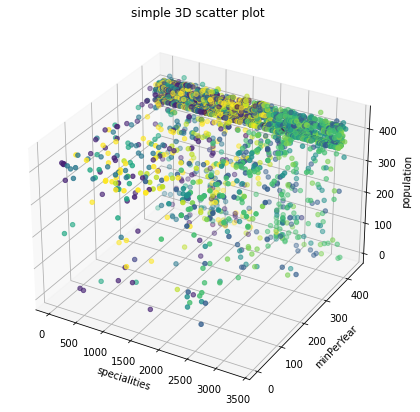

In [107]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Choose the columns have large std from the describe table
x=df_processed.specialities
y=df_processed.typeOfPractice
z=df_processed.population

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('specialities')
ax.set_ylabel('minPerYear')
ax.set_zlabel('population')
plt.title("simple 3D scatter plot")

## Test baseline.py

In [95]:
from customerclustering.baseline import *

In [122]:
df1=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

baseline=Baseline(df1,n_cluster=11).run()

model.joblib saved locally


# Feature engineering


- minPerYear                        

- specialities                        

- population                            

- typeOfPractice                        
- minCompleted- filter out >=150, then RobustScaler()

- focus                                  
- 2ndFavActivityType                    
- favActivityType                        
- complex                                
- access                                 

## Troubleshoot MinPerYear (drop this feature)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
nrow=200000
df_act=pd.read_sql_query(f"SELECT * FROM activity_20220808 LIMIT {nrow};", conn).drop_duplicates()
df_evt=pd.read_sql_query("SELECT * FROM tracking_event;", conn).drop_duplicates()
df_act_copy=df_act
df_evt_copy=df_evt

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(0.0, 200000000.0)

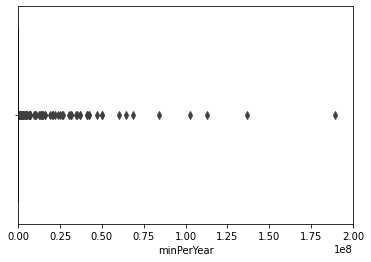

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.boxplot(x=df.minPerYear)
plt.xlim(0,0.2e9)

In [24]:
# get strange MinPerYear
df_strange=df[(df.minPerYear<0) | (df.minPerYear>0.2e9) ][['userID','minPerYear','account_age']]
df_strange

,userID,minPerYear,account_age
316,7556c09f-e6fa-4d78-b3cc-03b3803cb861,1.704075e+10,896.0
508,e001c4b1-bed4-4c69-97b0-e33f77c9ee22,-1.033053e+01,1497.0
581,008b0d78-1d06-4247-a39d-84fd86ae7637,4.102404e+08,584.0
691,059f3739-e729-4c85-98fa-a631a85505e8,-7.790379e+02,1562.0
874,0db8e835-4312-4c74-b19a-5935f6d7ffe9,-1.901193e+01,1610.0
964,11ae8539-f146-4d71-b2e1-bc515a122ae9,-1.217718e+01,1954.0
965,11b25805-5c90-482e-89ab-c9a647106bdd,-2.569708e+01,2006.0
1264,2080c5b3-b01a-40ba-8b69-fb796984b841,-2.388875e+01,1560.0
1375,25bfaf93-2b45-46f5-85d1-f5e25a44989e,-3.836636e+02,2007.0
1769,369902cd-133b-4880-982a-f76890cccedd,-6.267109e+01,1646.0


/var/folders/bh/j223y_td6s35mkxwj_m8bxdm0000gn/T/ipykernel_86019/3070009741.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_evt.rename(columns={'resourceID':'resource'},inplace=True)


In [15]:
df_act.describe()

,minOnAusmed,minPerYear,percentageOfLearningFromAusmed
count,65617.000000,6.561700e+04,65617.000000
mean,24.556655,1.434287e+08,0.301264
std,116.276423,2.048561e+09,0.430736
min,0.000000,5.904582e-02,0.000000
25%,0.000000,1.274257e+01,0.000000
50%,0.000000,1.262447e+02,0.000000
75%,17.000000,1.314873e+07,0.920000
max,18030.000000,3.155695e+11,1.000000


## 'minCompleted'

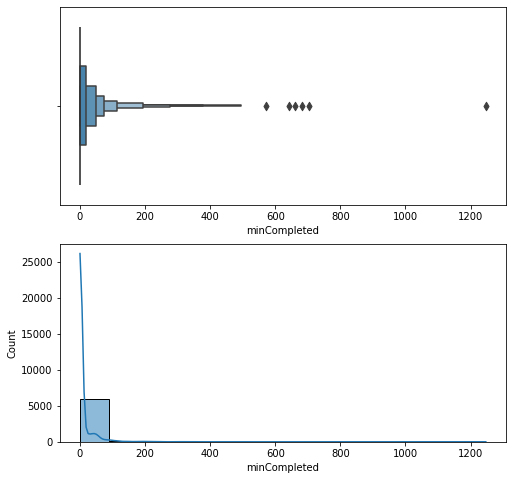

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
#fig, axplt.subplots
fig, ax = plt.subplots(2, figsize=(8,8))
sns.boxenplot(x=df.minCompleted,ax=ax[0])

sns.histplot(x=df.minCompleted,kde=True,ax=ax[1])


plt.show()


In [20]:
# get the fraction of outliers
len([df[df['minCompleted']>=150]])/len(df)

0.00016315875346712352

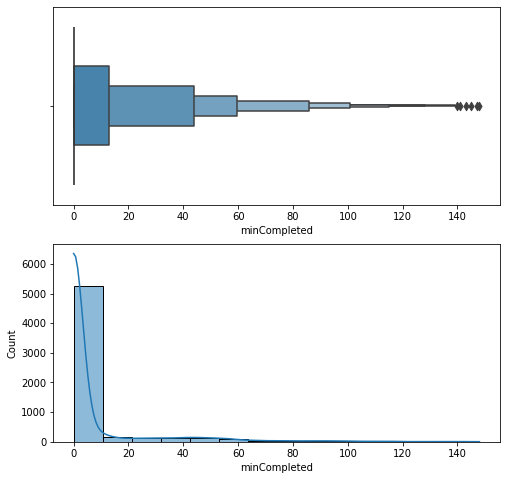

In [59]:
# plot filtered minComplted
import matplotlib.pyplot as plt
import seaborn as sns
#fig, axplt.subplots
df_f1=df[df['minCompleted']<150]
fig, ax = plt.subplots(2, figsize=(8,8))
sns.boxenplot(x=df_f1.minCompleted,ax=ax[0])

sns.histplot(x=df_f1.minCompleted,kde=True,ax=ax[1])


plt.show()


## Population

In [14]:
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

In [16]:
# check missing values
df.population.isna().sum()/len(df1)

0.0004894762604013706

In [20]:
df.describe().columns

Index(['num_subs', 'account_age', 'yearsOnAusmed', 'min', 'minOnAusmed',
       'minOnAusmedPerYear', 'minPerYear', 'percentageOfLearningFromAusmed',
       'numQueued', 'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'subscribe_days', 'GoalsPerYear',
       'ratioOfAchivedGoals'],
      dtype='object')

# Get Outliers



In [116]:
import pandas as pd
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

num_subs


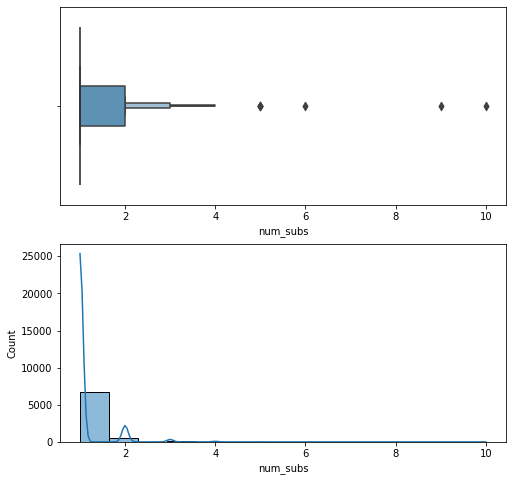

account_age


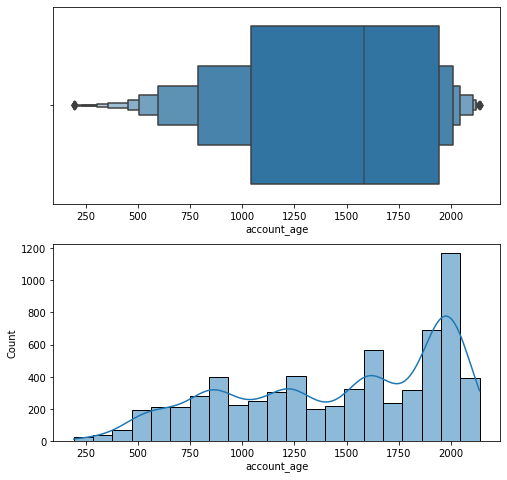

hasPracticeRecord


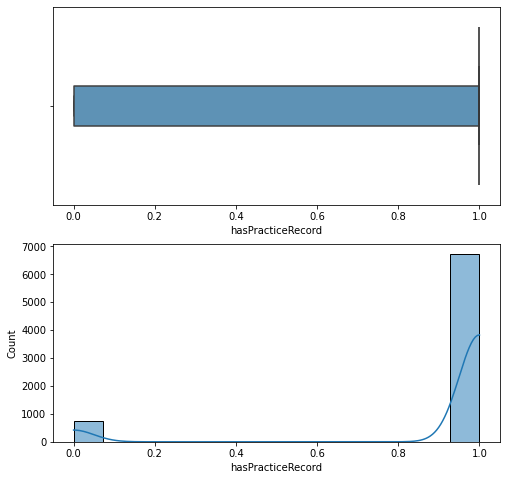

docPerYear


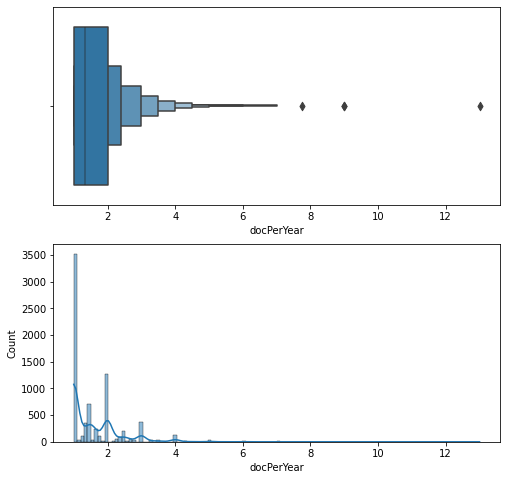

docOnAusmedPerYear


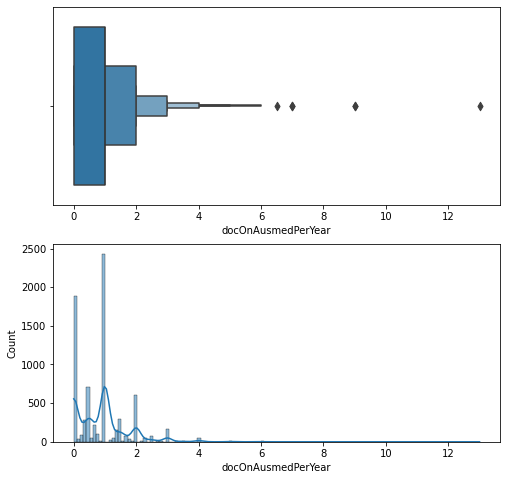

minPerYear


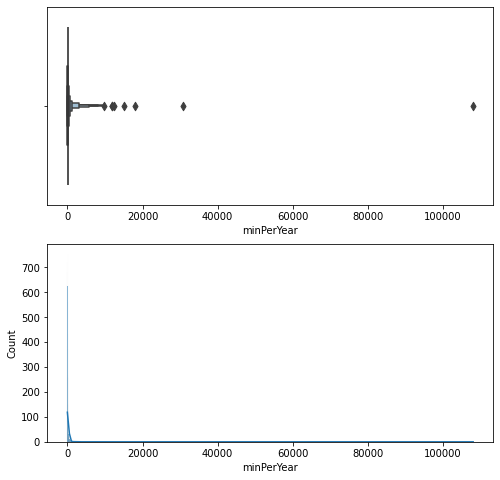

minOnAusmedPerYear


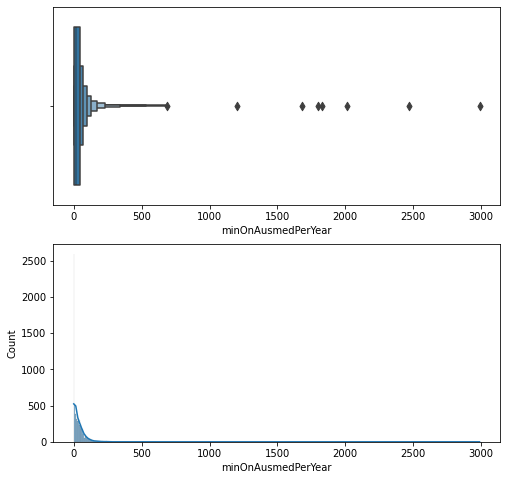

learnFromAusmedRatio_num


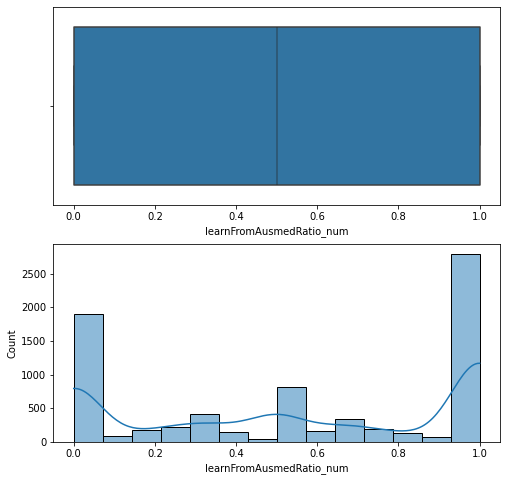

learnFromAusmedRatio_min


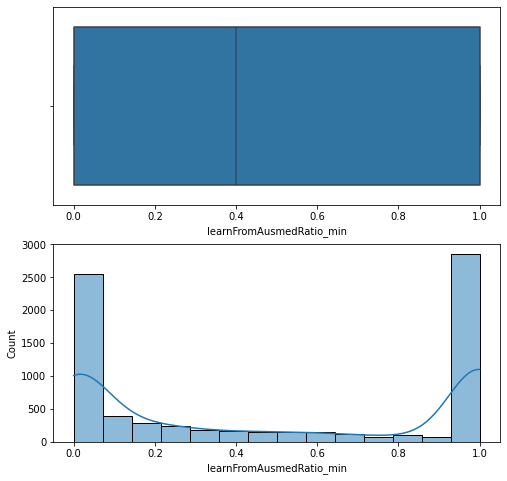

numQueuedPerYear


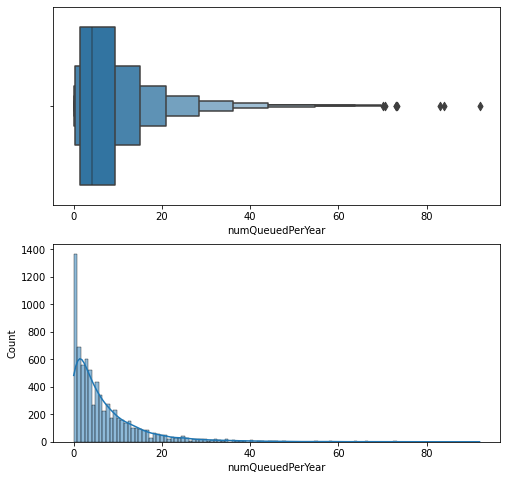

numCompletedOnelinePerYear


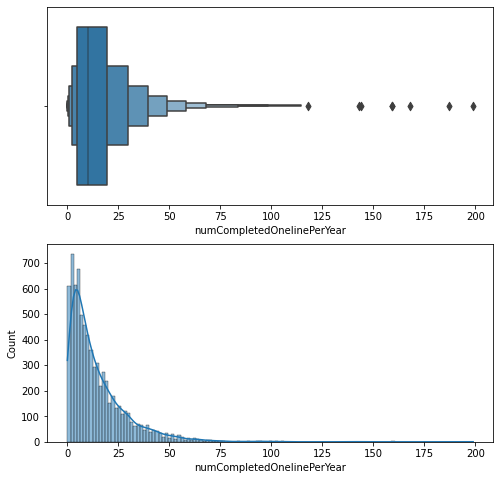

numCompletedFromQueuePerYear


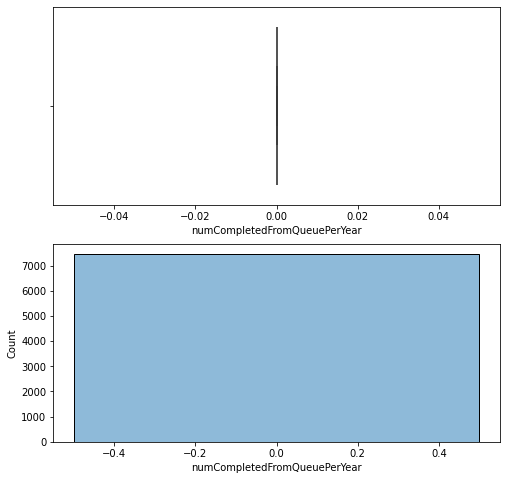

minCompletedOnelinePerYear


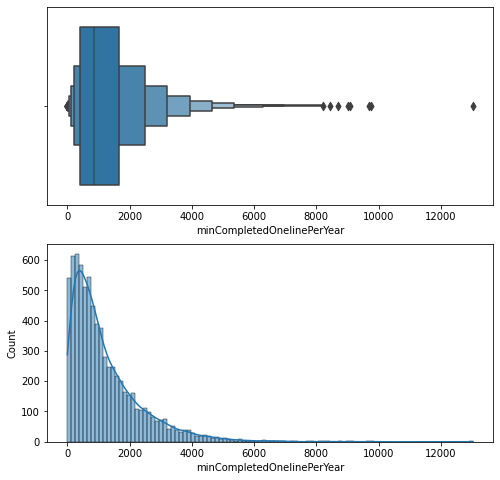

minQueuedPerYear


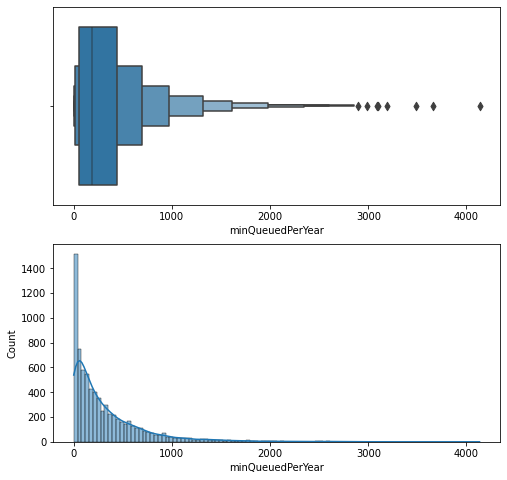

minCompletedFromQueuePerYear


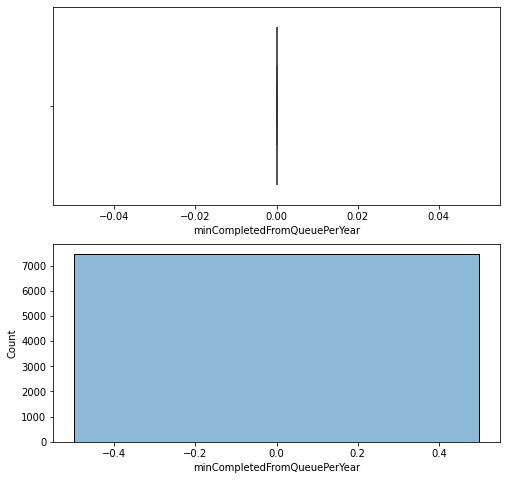

event_cpd_day_diff


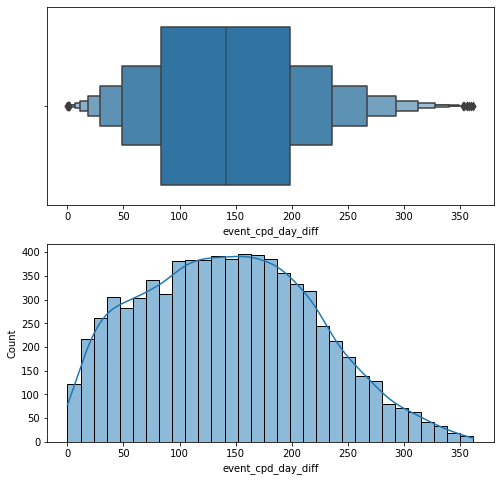

doc_in_activation


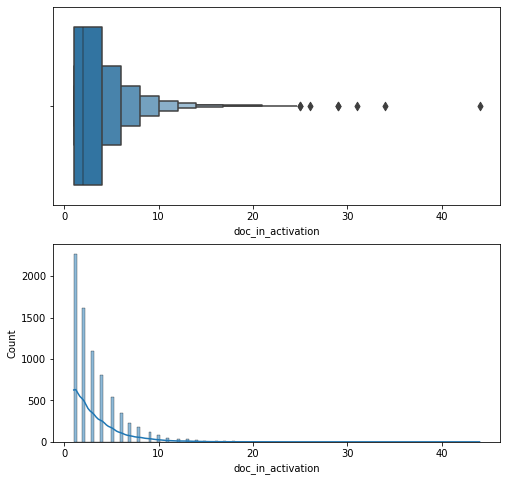

activated


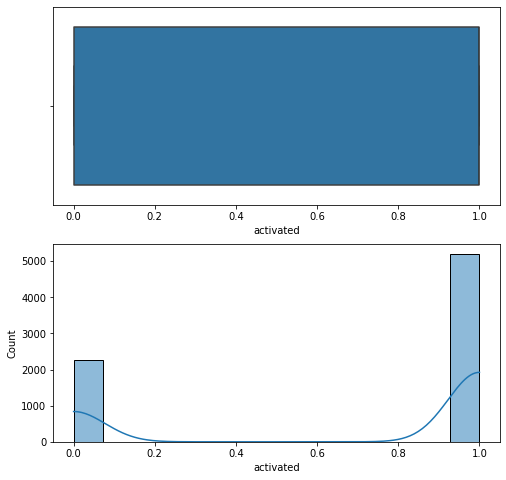

subscribe_days


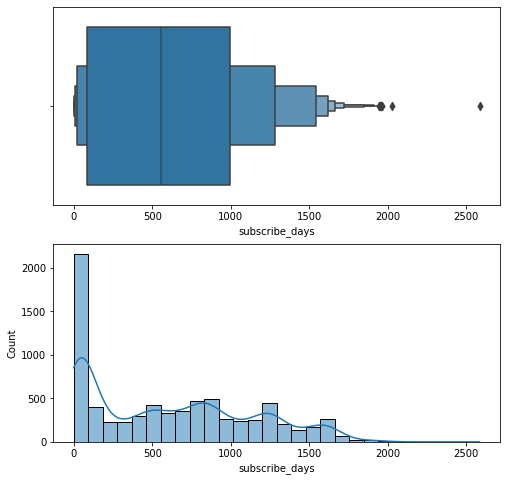

GoalsPerYear


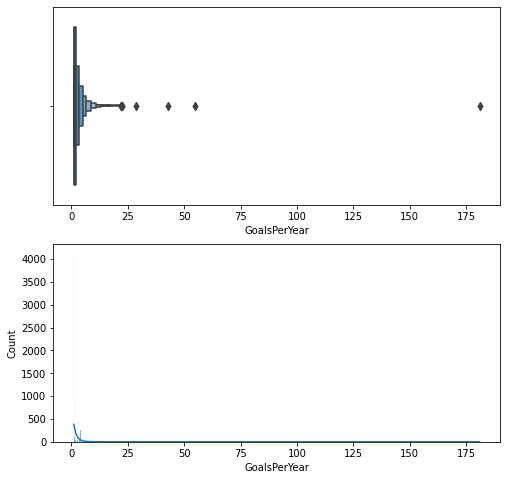

ratioOfAchivedGoals


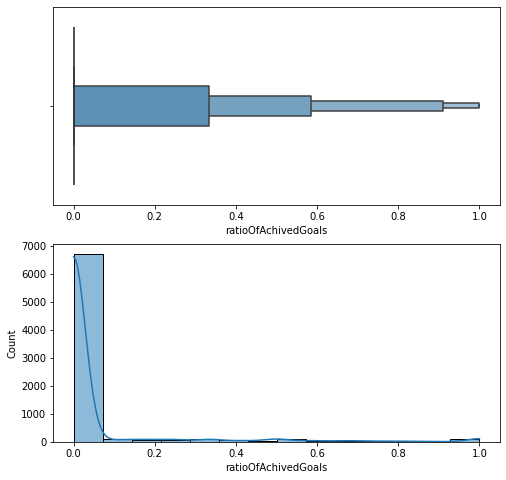

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

col_inuse=[feature for feature in  df.describe().columns ]

for feature in col_inuse:
    print(feature)
    fig, ax=plt.subplots(2, figsize=(8,8))
    sns.boxenplot(x=df[f'{feature}'],ax=ax[0])
    sns.histplot(x=df[f'{feature}'],kde=True,ax=ax[1])
    plt.show()




In [128]:
# clean the data
#outliers are from 'docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear'
import numpy as np
from scipy import stats

#df[(np.abs(stats.zscore(df[num_col])) >10).all(axis=1)]
#df[(np.abs(stats.zscore(df[num_col])) <10).all(axis=1)]
col_drop=['numCompletedFromQueuePerYear','minCompletedFromQueuePerYear',
          'numCompletedFromQueuePerYear','minCompletedFromQueuePerYear']

threshold=1-0.007
df.quantile(1-threshold)
#num_otl=['docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear','minPerYear']

thr_dpy=df.docPerYear.quantile(threshold)
thr_dapy=1000

thr_gpy=25
thr_mpy=3000
thr_mapy=500

#df_cleaned=df[(df.docPerYear<thr_dpy) & (df.docOnAusmedPerYear<thr_dapy) &
#               (df.numQueued<thr_nq)& (df.minQueued<thr_mq)& (df.minCompleted<thr_nq)&
#               (df.GoalsPerYear<thr_gpy) & (df.minPerYear<thr_mpy) & (df.minOnAusmedPerYear<thr_mapy)]


df_cleaned=df[(df.minPerYear<thr_mpy)& (df.GoalsPerYear<thr_gpy) & (df.minOnAusmedPerYear<thr_mapy)]
df_cleaned.drop(columns=col_drop,inplace=True)


print(f'the percentage of data disgarded is {1-len(df_cleaned)/len(df)}')

the percentage of data disgarded is 0.01055867415129641


/var/folders/bh/j223y_td6s35mkxwj_m8bxdm0000gn/T/ipykernel_40461/344263523.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=col_drop,inplace=True)


In [124]:
# df[(np.abs(stats.zscore(df[num_col])) <10).all(axis=1)]
# np.abs(stats.zscore(df[num_col]))

In [125]:
df.quantile(1-threshold)

num_subs                          1.000000
account_age                     343.456000
hasPracticeRecord                 0.000000
docPerYear                        1.000000
docOnAusmedPerYear                0.000000
minPerYear                        3.000000
minOnAusmedPerYear                0.000000
learnFromAusmedRatio_num          0.000000
learnFromAusmedRatio_min          0.000000
numQueuedPerYear                  0.000000
numCompletedOnelinePerYear        0.000000
numCompletedFromQueuePerYear      0.000000
minCompletedOnelinePerYear        9.000000
minQueuedPerYear                  0.000000
minCompletedFromQueuePerYear      0.000000
event_cpd_day_diff                6.120861
doc_in_activation                 1.000000
activated                         0.000000
subscribe_days                    0.000000
GoalsPerYear                      1.000000
ratioOfAchivedGoals               0.000000
Name: 0.007000000000000006, dtype: float64

num_subs


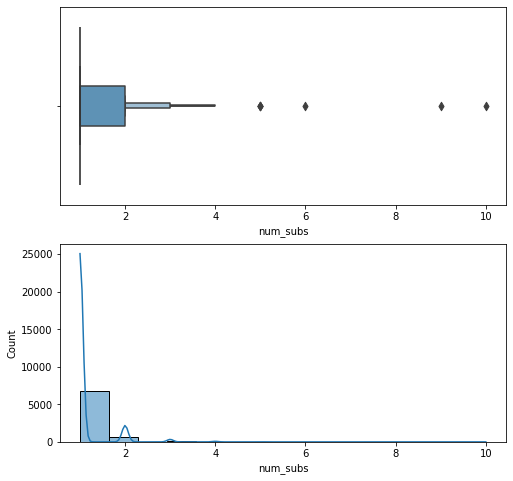

account_age


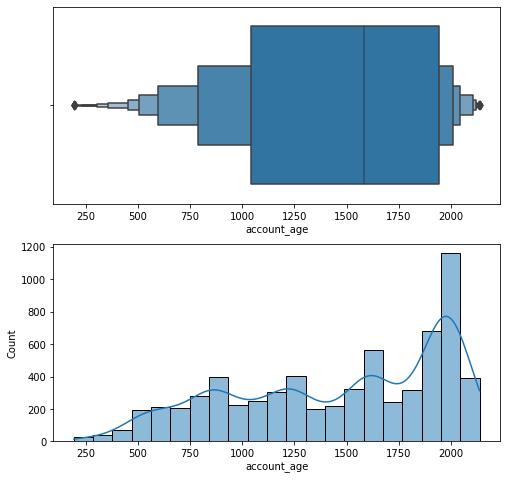

hasPracticeRecord


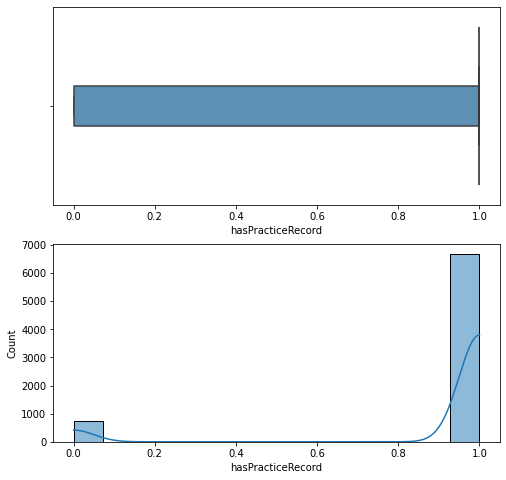

docPerYear


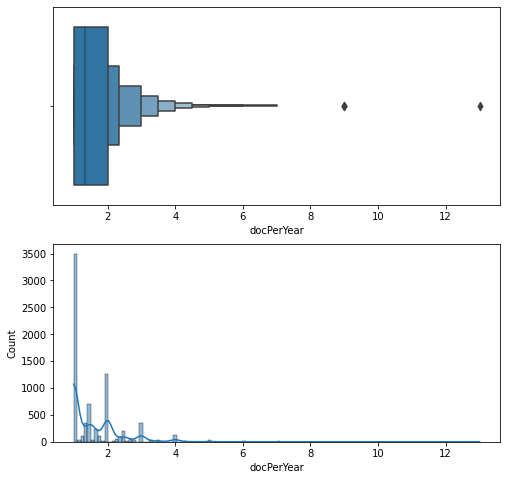

docOnAusmedPerYear


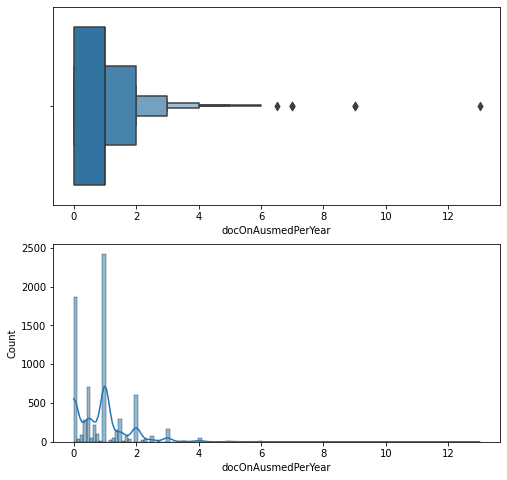

minPerYear


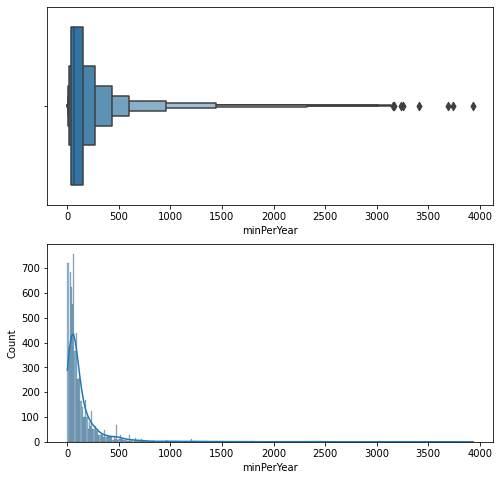

minOnAusmedPerYear


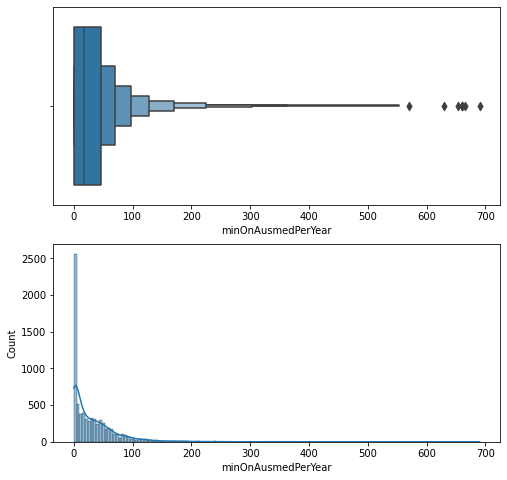

learnFromAusmedRatio_num


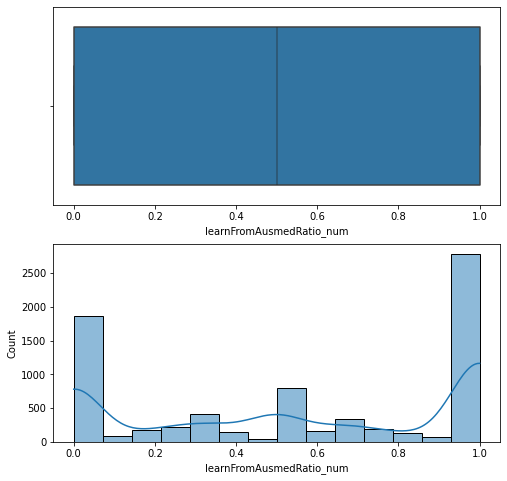

learnFromAusmedRatio_min


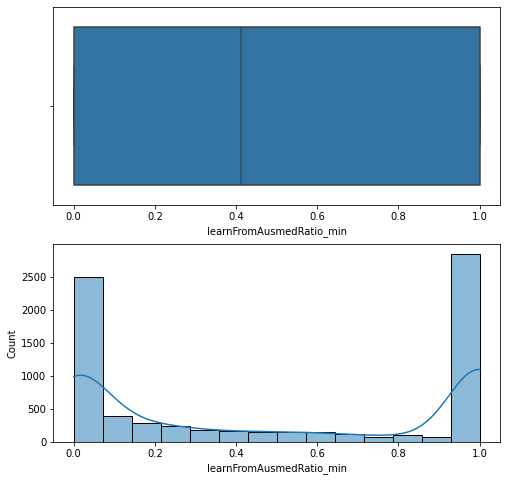

numQueuedPerYear


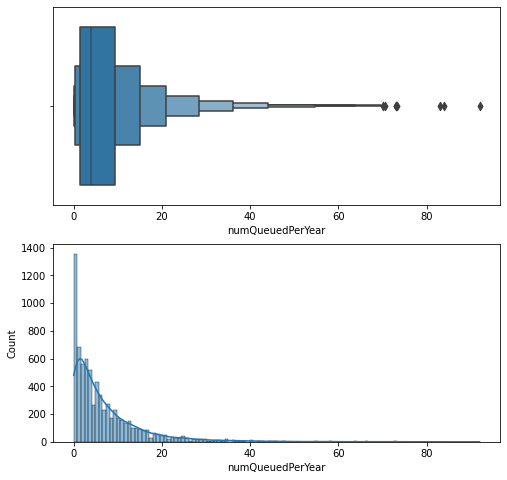

numCompletedOnelinePerYear


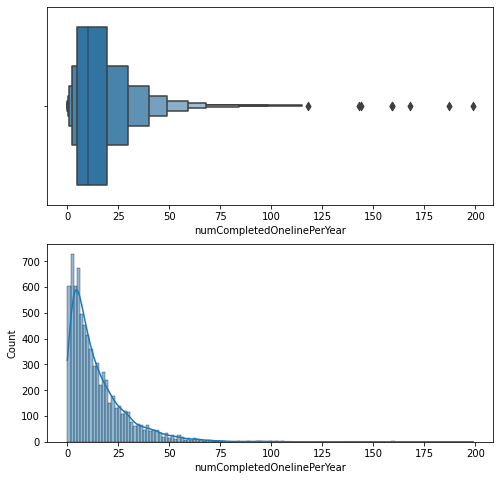

minCompletedOnelinePerYear


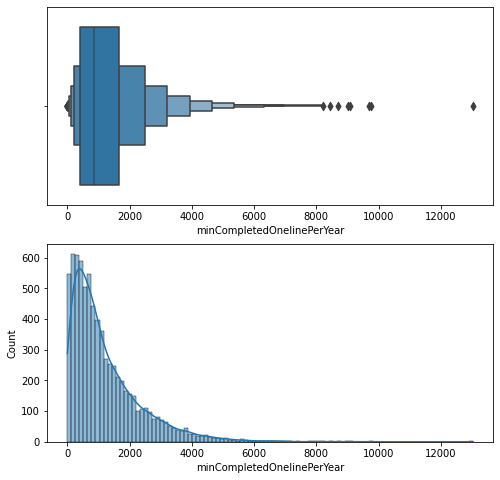

minQueuedPerYear


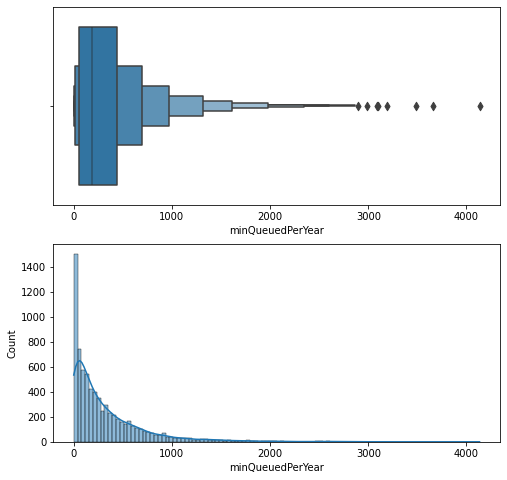

event_cpd_day_diff


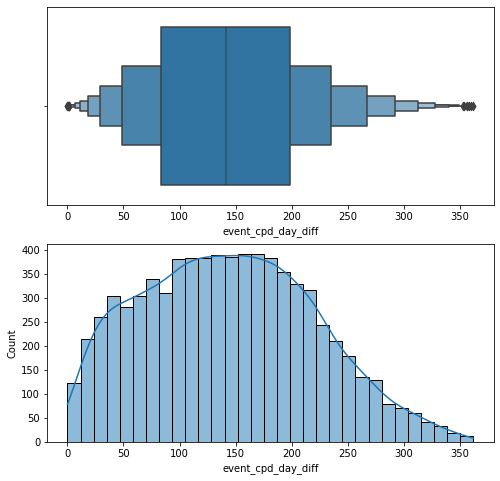

doc_in_activation


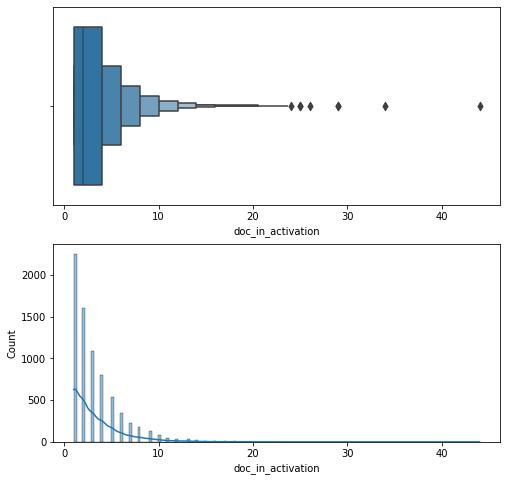

activated


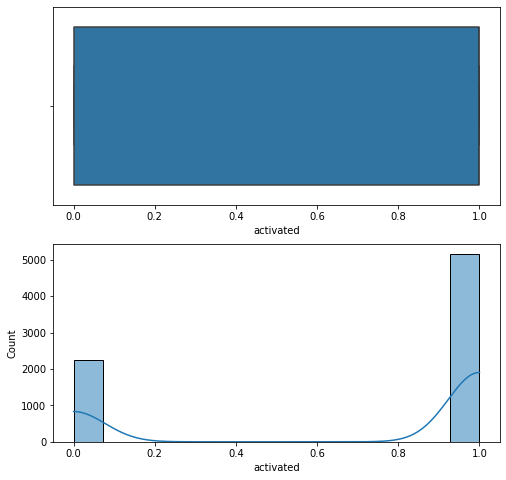

subscribe_days


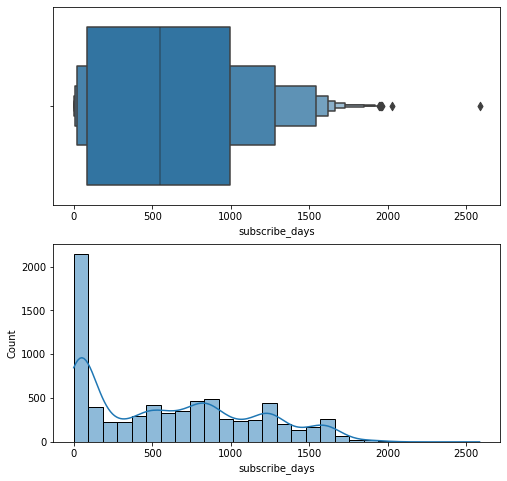

GoalsPerYear


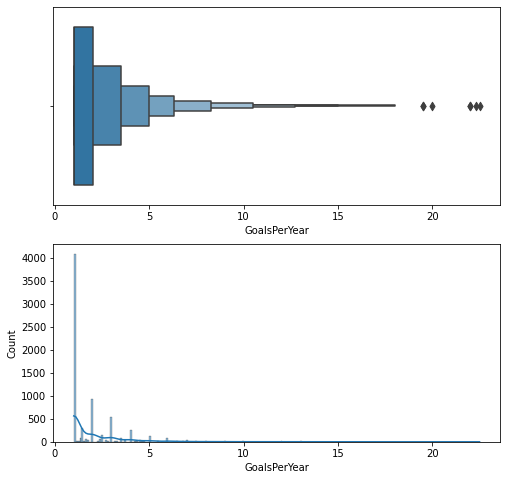

ratioOfAchivedGoals


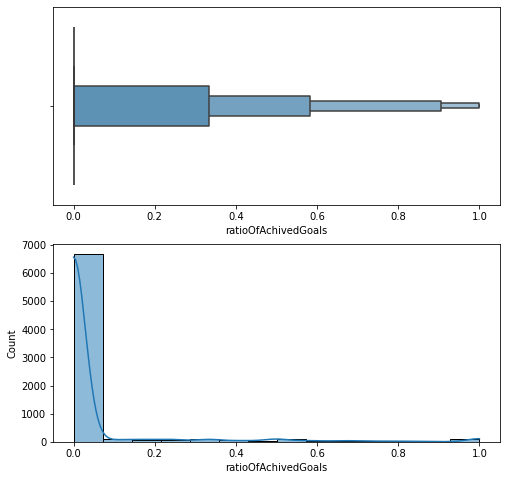

In [122]:
# plot the numerical columns and check again
import matplotlib.pyplot as plt
import seaborn as sns
#col_inuse=[feature for feature in  df.describe().columns if feature not in col_not_inuse]

for feature in df_cleaned.describe():
    print(feature)
    fig, ax=plt.subplots(2, figsize=(8,8))
    sns.boxenplot(x=df_cleaned[f'{feature}'],ax=ax[0])
    sns.histplot(x=df_cleaned[f'{feature}'],kde=True,ax=ax[1])
    plt.show()

In [124]:
df_cleaned[num_col].isna().sum()/len(df_cleaned)# only account_age has missing value
print(f'the mean of account_age is {df_cleaned.account_age.mean()}')
print(f'the median of account_age is {df_cleaned.account_age.median()}')

the mean of account_age is 1451.2120784313724
the median of account_age is 1572.0


In [130]:
df_cleaned[cat_col].nunique()

Product                     8
Status                      5
userID                   7058
stripeCustID             7058
pProfileID               7058
typeOfPractice            457
located                     7
specialities             3454
population                451
focus                     419
complex                     8
autonomy                    6
access                      4
country                     7
activityType               12
secondFavActivityType      13
plan_type                   3
metaGoalTitle            6963
dtype: int64

In [131]:
df_cleaned.unique()

array(['quarterly', 'monthly', 'annually'], dtype=object)

In [139]:
from sklearn.preprocessing import OrdinalEncoder
## preprocess categorical data
cat_col=[col for col in df_cleaned.columns if col not in num_col]


# select the ones with only a few unique values
cat_ord=['Status', 'access', 'plan_type','located'] 

# check missing values
df_cleaned[cat_col_sel0].isna().sum()/len(df_cleaned) 

# order columns
feature_1_sorted_values = ['remote area','other rural area','small rural centre',
                           'large rural centre','other metropolitan centre','metropolitan centre','capital city'] # 'located', need to check this 
feature_2_sorted_values = ['canceled','incomplete_expired','past_due', 'trialing','active',]
feature_3_sorted_values = ['never','sometimes' ,'usually','always']
feature_4_sorted_values = ['monthly','quarterly',  'annually']


# create categories iteratively: the shape of categories has to be (n_feature,)
categories=[]

categories_base=[
        
        feature_1_sorted_values,
        feature_2_sorted_values,
        feature_3_sorted_values,
        feature_4_sorted_values
    ]

for col in cat_ord:
    #print(set(X_cat[col].unique()))
    for values in categories_base:
    
        if set(values).isdisjoint(set(df_cleaned[col]))==False:
            categories.append(values)


print(categories) 

ord_enc = OrdinalEncoder(
    categories=categories,
    #handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)


[['canceled', 'incomplete_expired', 'past_due', 'trialing', 'active'], ['never', 'sometimes', 'usually', 'always'], ['monthly', 'quarterly', 'annually']]


# The model

## version0: PCA+Kmeans

In [55]:
# clean the data
#outliers are from 'docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear'
import numpy as np
from scipy import stats

df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

threshold=1-0.007
df.quantile(1-threshold)
num_otl=['docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear','minPerYear']

thr_dpy=df.docPerYear.quantile(threshold)
thr_dapy=df.docOnAusmedPerYear.quantile(threshold)
thr_nq=df.numQueued.quantile(threshold)
thr_mq=df.minQueued.quantile(threshold)
thr_mc=df.minCompletedFromQueue.quantile(threshold)
thr_gpy=df.GoalsPerYear.quantile(threshold)
thr_mpy=df.minPerYear.quantile(threshold)
thr_mapy=df.minOnAusmedPerYear.quantile(threshold)

df_cleaned=df[(df.docPerYear<thr_dpy) & (df.docOnAusmedPerYear<thr_dapy) &
              (df.numQueued<thr_nq)& (df.minQueued<thr_mq)& (df.minCompletedFromQueue<thr_nq)&
              (df.GoalsPerYear<thr_gpy) & (df.minPerYear<thr_mpy) & (df.minOnAusmedPerYear<thr_mapy)]

print(f'the percentage of data disgarded is {1-len(df_cleaned)/len(df)}')

AttributeError: 'DataFrame' object has no attribute 'numQueued'

In [42]:
from sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
## preprocess categorical data
cat_col=[col for col in df_cleaned.columns if col not in num_col]


# select the ones with only a few unique values
cat_ord=['located','Status', 'access', 'plan_type']


# check missing values
df_cleaned[cat_col_sel0].isna().sum()/len(df_cleaned) 

# order columns
feature_1_sorted_values = ['remote area','other rural area','small rural centre',
                           'large rural centre','other metropolitan centre','metropolitan centre','capital city'] # 'located', need to check this 
feature_2_sorted_values = ['canceled','incomplete_expired','past_due', 'trialing','active',]
feature_3_sorted_values = ['never','sometimes' ,'usually','always']
feature_4_sorted_values = ['monthly','quarterly',  'annually']


# create categories iteratively: the shape of categories has to be (n_feature,)
categories=[]

categories_base=[
        
        feature_1_sorted_values,
        feature_2_sorted_values,
        feature_3_sorted_values,
        feature_4_sorted_values
    ]

for col in cat_ord:
    #print(set(X_cat[col].unique()))
    for values in categories_base:
    
        if set(values).isdisjoint(set(df_cleaned[col]))==False:
            categories.append(values)


print(categories) 

ord_enc = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)


NameError: name 'num_col' is not defined

In [203]:
# Robustscaler all numerical columns
num_transformer=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(ord_enc,RobustScaler())


preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_ord),remainder='drop')


In [8]:
df_processed=preproc.fit_transform(df_cleaned)
pca=PCA()
df_proj=pd.DataFrame(pca.fit_transform(df_processed),columns=[f'PC{i}' for i in range(1, len(num_col)+len(cat_ord)+1)])
df_proj

NameError: name 'preproc' is not defined

<AxesSubplot:>

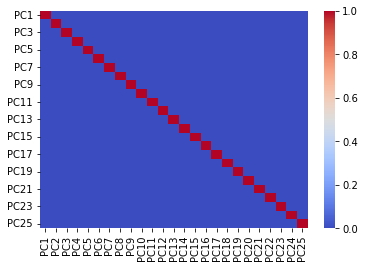

In [205]:
sns.heatmap(df_proj.corr(), cmap='coolwarm')

In [13]:
# get the weights
# Access our PCs 
v0_W = pca.components_

# Print PCs as COLUMNS
v0_W = pd.DataFrame(v0_W.T,
                 index=num_col.to_list()+cat_ord,
                 columns=[f'PC{i}' for i in range(1, len(num_col)+len(cat_ord)+1)])

v0_W.style.applymap(lambda x: "background-color: yellow" if abs(x)>0.01 else "background-color: white")
# select top 5 factors dominating the first three PCs


NameError: name 'pca' is not defined

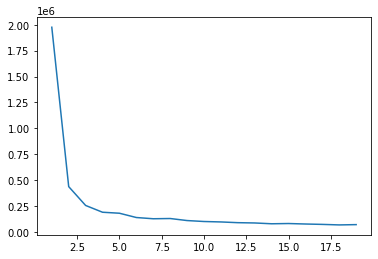

In [165]:
# Let's MiniKmeans!
import matplotlib.pyplot as plt

# find the optimal n_cluster

# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_proj).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss);

In [ ]:
# it looks 3,4 components are enough!
# we may play around with 3,4,5,6


## Visualize data on the first 2 component 

In [183]:
pipe=make_pipeline(preproc,PCA(),MiniBatchKMeans(n_clusters=4))

In [184]:
df_proj['label']=pipe.fit_predict(df_cleaned)

In [185]:
df_proj.label.value_counts()

0    6220
1     362
2     355
3     121
Name: label, dtype: int64

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

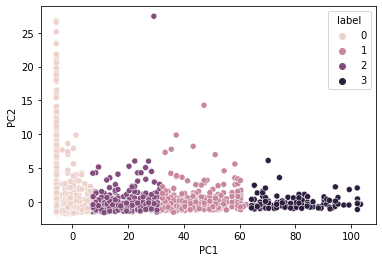

In [189]:
import seaborn as sns
sns.scatterplot(df_proj.PC1,df_proj.PC2, hue=df_proj.label)

## Compare with no pca

the percentage of data disgarded is 0.05666933974873034


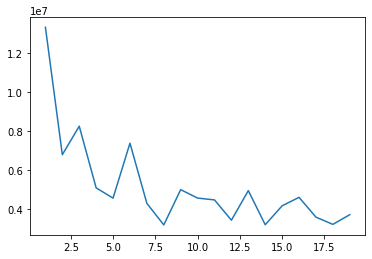

In [222]:
import numpy as np
from scipy import stats

df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

threshold=1-0.007
df.quantile(1-threshold)
num_otl=['docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear','minPerYear']

thr_dpy=df.docPerYear.quantile(threshold)
thr_dapy=df.docOnAusmedPerYear.quantile(threshold)
thr_nq=df.numQueued.quantile(threshold)
thr_mq=df.minQueued.quantile(threshold)
thr_mc=df.minCompleted.quantile(threshold)
thr_gpy=df.GoalsPerYear.quantile(threshold)
thr_mpy=df.minPerYear.quantile(threshold)
thr_mapy=df.minOnAusmedPerYear.quantile(threshold)

df_cleaned=df[(df.docPerYear<thr_dpy) & (df.docOnAusmedPerYear<thr_dapy) &
              (df.numQueued<thr_nq)& (df.minQueued<thr_mq)& (df.minCompleted<thr_nq)&
              (df.GoalsPerYear<thr_gpy) & (df.minPerYear<thr_mpy) & (df.minOnAusmedPerYear<thr_mapy)]

print(f'the percentage of data disgarded is {1-len(df_cleaned)/len(df)}')

from sklearn.preprocessing import RobustScaler,OrdinalEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
## preprocess categorical data
cat_col=[col for col in df_cleaned.columns if col not in num_col]


# select the ones with only a few unique values
cat_ord=['located','Status', 'access', 'plan_type']


# check missing values
df_cleaned[cat_col_sel0].isna().sum()/len(df_cleaned) 

# order columns
feature_1_sorted_values = ['remote area','other rural area','small rural centre',
                           'large rural centre','other metropolitan centre','metropolitan centre','capital city'] # 'located', need to check this 
feature_2_sorted_values = ['canceled','incomplete_expired','past_due', 'trialing','active',]
feature_3_sorted_values = ['never','sometimes' ,'usually','always']
feature_4_sorted_values = ['monthly','quarterly',  'annually']


# create categories iteratively: the shape of categories has to be (n_feature,)
categories=[]

categories_base=[
        
        feature_1_sorted_values,
        feature_2_sorted_values,
        feature_3_sorted_values,
        feature_4_sorted_values
    ]

for col in cat_ord:
    #print(set(X_cat[col].unique()))
    for values in categories_base:
    
        if set(values).isdisjoint(set(df_cleaned[col]))==False:
            categories.append(values)


#print(categories) 

ord_enc = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)

# Robustscaler all numerical columns
num_transformer=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(ord_enc,RobustScaler())


preproc=make_column_transformer((num_transformer,num_col),(cat_transformer,cat_ord),remainder='drop')

df_processed=pd.DataFrame(preproc.fit_transform(df),columns=num_col.tolist()+cat_ord)

# Let's MiniKmeans!
import matplotlib.pyplot as plt

# find the optimal n_cluster

# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss);


The optimal cluster size is 8


Text(0.5, 0.92, 'simple 3D scatter plot')

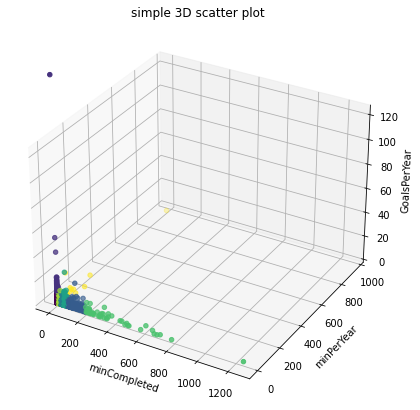

In [227]:
# The baseline model
print(f"The optimal cluster size is {clusters[wcss.index(min(wcss))]}") # this gives 14

model_v0=MiniBatchKMeans(n_clusters=8)
X_pred=model_v0.fit(df_processed).predict(df_processed)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


# Choose the columns have large std from the describe table
x=df_processed.minCompleted
y=df_processed.minPerYear
z=df_processed.GoalsPerYear

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('minCompleted')
ax.set_ylabel('minPerYear')
ax.set_zlabel('GoalsPerYear')
ax.set_zlim(0,125)
plt.title("simple 3D scatter plot")



(-10.0, 400.0)

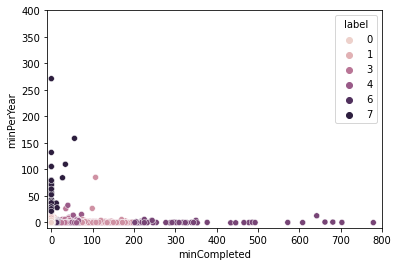

In [231]:
df_processed['label']=X_pred
sns.scatterplot(x=df_processed.minCompleted,y=df_processed.minPerYear,hue=df_processed.label)
plt.xlim(-10,800)
plt.ylim(-10,400) # we have oustanding outliers in both x and y axes

## Rerun Kmeans with important features only 


-- **the result is surprisingly the same with PCA!!!**

-- Chaotic columns: 'RatioOfCompletion_num','RatioOfCompletion_min','num_subs') tested

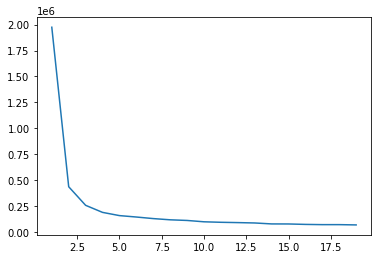

In [238]:
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

threshold=1-0.007
df.quantile(1-threshold)
num_otl=['docPerYear','docOnAusmedPerYear','numQueued','minQueued','minCompleted','GoalsPerYear','minPerYear']

thr_dpy=df.docPerYear.quantile(threshold)
thr_dapy=df.docOnAusmedPerYear.quantile(threshold)
thr_nq=df.numQueued.quantile(threshold)
thr_mq=df.minQueued.quantile(threshold)
thr_mc=df.minCompleted.quantile(threshold)
thr_gpy=df.GoalsPerYear.quantile(threshold)
thr_mpy=df.minPerYear.quantile(threshold)
thr_mapy=df.minOnAusmedPerYear.quantile(threshold)

df_cleaned=df[(df.docPerYear<thr_dpy) & (df.docOnAusmedPerYear<thr_dapy) &
              (df.numQueued<thr_nq)& (df.minQueued<thr_mq)& (df.minCompleted<thr_nq)&
              (df.GoalsPerYear<thr_gpy) & (df.minPerYear<thr_mpy) & (df.minOnAusmedPerYear<thr_mapy)]



df_cleaned1=df_cleaned.drop(columns=['RatioOfCompletion_num','RatioOfCompletion_min','num_subs'])

num_col1=df_cleaned1.describe().columns
preproc1=make_column_transformer((num_transformer,num_col1),(cat_transformer,cat_ord),remainder='drop')
df_processed=preproc1.fit_transform(df_cleaned1)


# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss); # same as with pca!!!!

Text(0.5, 0.92, 'simple 3D scatter plot')

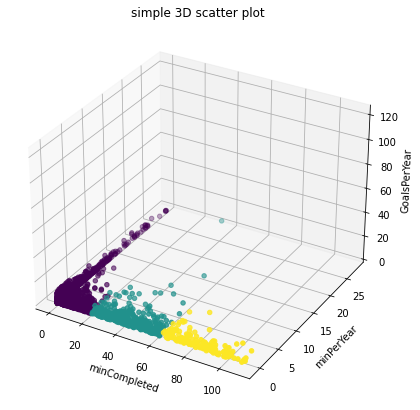

In [241]:
model_v1=MiniBatchKMeans(n_clusters=3)
X_pred=model_v1.fit(df_processed).predict(df_processed)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

df_processed=pd.DataFrame(df_processed,columns=num_col1.tolist()+cat_ord)

# Choose the columns have large std from the describe table
x=df_processed.minCompleted
y=df_processed.minPerYear
z=df_processed.GoalsPerYear

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
# Creating plot
ax.scatter3D(x, y, z, c = X_pred)
ax.set_xlabel('minCompleted')
ax.set_ylabel('minPerYear')
ax.set_zlabel('GoalsPerYear')
ax.set_zlim(0,125)
plt.title("simple 3D scatter plot")

<AxesSubplot:>

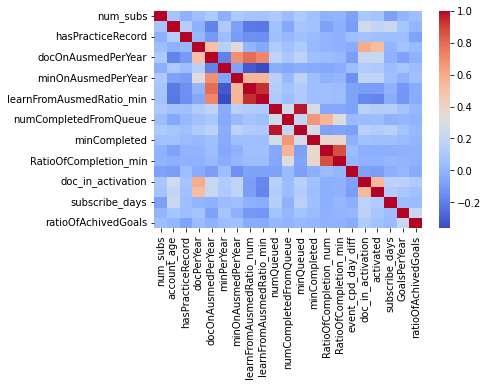

In [137]:
import seaborn as sns
sns.heatmap(df_cleaned.corr(), cmap='coolwarm')

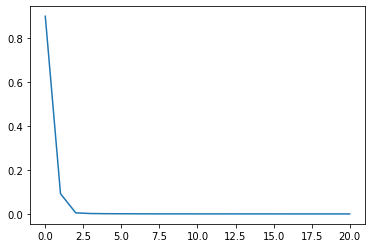

In [41]:
# to get the number of components to use
plt.plot(pca.explained_variance_ratio_)


In [42]:
df.specialities.

0                      Rehabilitation,Aged care ,Medical 
1                           Addiction and Substance Abuse
2                            Immunisation,Chronic Illness
3       aged care; wound care and the continuity of he...
4                                                     NaN
                              ...                        
7477                                Residential Aged Care
7478                           Wound care,Palliative care
7479                        Respiratory,Diabetes Mellitus
7480                                 Extended Day Surgery
7481                                Residential Aged Care
Name: specialities, Length: 7482, dtype: object

## Version1: PCA+ Kmeans

In [160]:
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df.columns

Index(['Product', 'Status', 'userID', 'stripeCustID', 'num_subs',
       'account_age', 'pProfileID', 'typeOfPractice', 'located',
       'specialities', 'population', 'focus', 'complex', 'autonomy', 'access',
       'country', 'hasPracticeRecord', 'docPerYear', 'docOnAusmedPerYear',
       'minPerYear', 'minOnAusmedPerYear', 'learnFromAusmedRatio_num',
       'learnFromAusmedRatio_min', 'activityType', 'secondFavActivityType',
       'numQueuedPerYear', 'numCompletedOnelinePerYear',
       'numCompletedFromQueuePerYear', 'minCompletedOnelinePerYear',
       'minQueuedPerYear', 'minCompletedFromQueuePerYear',
       'event_cpd_day_diff', 'doc_in_activation', 'activated', 'plan_type',
       'subscribe_days', 'GoalsPerYear', 'ratioOfAchivedGoals',
       'metaGoalTitle'],
      dtype='object')

In [162]:
# step 0 run pca to select features
import seaborn as sns
import matplotlib.pyplot as plt
from customerclustering.trainer import *
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df.head()


trainer=Trainer(df,'model_v0')
df=trainer.df
preproc=trainer.preprocessing()
df_processed=preproc.fit_transform(df)


## pca
pca=PCA()

df_proj=pca.fit_transform(df_processed)
df_proj=pd.DataFrame(df_proj,columns=[f'PC{i}' for i in range(df_processed.shape[1])])


# df['label']=
# #sns.scatterplot(x=df_proj.minCompleted,y=df_proj.minPerYear,hue=df_proj.label)
# sns.scatterplot(x=df_proj.PC1,y=df_proj.PC2,hue=df_proj.label)
#  # we have oustanding outliers in both x and y axes

/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=col_drop,inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have a high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

In [168]:
# get the weights
# Access our PCs 
num_col=df.describe().columns
cat_ord=['located','Status', 'access', 'plan_type','autonomy','complex']
        #select columns for MinMax
num_minmax=['activated','ratioOfAchivedGoals','learnFromAusmedRatio_num',
           'hasPracticeRecord','learnFromAusmedRatio_min']


        #select columns for Robustscaler
num_robust=[col for col in df.describe().columns if col not in num_minmax]



v0_W = pca.components_

# Print PCs as COLUMNS
v0_W = pd.DataFrame(v0_W.T,
                 index=num_robust+num_minmax+cat_ord,
                 columns=[f'PC{i}' for i in range(1, len(num_robust)+len(num_minmax)+len(cat_ord)+1)])

v0_W.style.applymap(lambda x: "background-color: yellow" if abs(x)>0.05 else "background-color: white")
# select top 5 factors dominating the first three PCs


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25
num_subs,-0.004820,0.021513,-0.013207,-0.005425,0.027037,0.000457,0.054604,-0.015371,-0.099650,0.061220,0.118520,0.013634,0.077528,-0.009057,0.246184,0.008220,0.931101,0.111588,-0.139064,0.035412,-0.016062,-0.009427,-0.018144,-0.003256,0.001908
account_age,0.034053,-0.014988,0.053691,-0.023020,0.028260,0.211438,0.044854,-0.419025,-0.079947,0.166742,0.319470,-0.094620,-0.293623,-0.048544,0.461315,-0.485459,-0.200707,0.064142,-0.208704,-0.006914,-0.036686,0.019033,0.008250,-0.004083,-0.006935
docPerYear,0.049248,0.155731,-0.112261,-0.063418,0.361692,0.235182,-0.251976,0.321663,-0.130138,0.042892,-0.286936,0.061184,-0.171952,0.117412,-0.199034,-0.413078,0.067935,0.253890,-0.001398,-0.244329,-0.324900,0.038240,-0.023188,-0.005503,-0.093761
docOnAusmedPerYear,-0.074977,0.179692,-0.200230,-0.053365,0.361591,-0.247614,-0.276100,0.107378,-0.008600,-0.029769,-0.200508,0.018031,-0.369230,-0.064329,0.272190,0.054509,-0.005583,-0.064037,0.004705,0.220181,0.542533,-0.030902,0.092336,0.006918,0.154293
minPerYear,0.964287,-0.037384,-0.221722,0.044686,-0.030524,-0.106578,0.014126,-0.010131,0.011820,-0.011096,-0.015883,-0.003706,-0.029363,-0.021887,0.035779,0.040096,0.001097,-0.012845,0.001001,-0.002537,-0.004187,-0.000712,-0.000064,0.001373,0.007157
minOnAusmedPerYear,-0.026217,0.181265,-0.180978,-0.039598,0.315065,-0.395203,-0.312613,-0.379287,-0.070304,0.094032,0.299090,-0.017094,0.461116,0.090480,-0.266315,-0.131148,-0.041728,0.071624,-0.044278,0.097740,-0.037056,-0.008978,-0.036092,0.004859,-0.038245
numQueuedPerYear,-0.030480,0.336622,-0.237400,-0.219728,-0.456781,0.137783,-0.256702,-0.009063,-0.045314,0.006515,-0.041174,0.019342,-0.008785,-0.007940,0.024503,0.053491,-0.008149,0.004561,-0.060699,0.360789,-0.260267,0.066389,0.522700,-0.018763,0.009222
numCompletedOnelinePerYear,-0.054794,0.283579,-0.265171,-0.129143,0.197865,-0.079560,0.598263,0.160060,0.201947,-0.050161,0.060025,-0.066337,-0.074081,-0.009417,-0.024285,-0.048560,-0.058424,0.019392,-0.078261,0.442184,-0.239786,0.022391,-0.277240,0.001419,-0.020963
minCompletedOnelinePerYear,-0.047410,0.315657,-0.266742,-0.157625,-0.029987,-0.057591,0.391954,-0.013698,0.103915,0.005523,0.130709,-0.043957,0.029474,0.017994,-0.080966,-0.083297,0.028589,-0.023524,0.072112,-0.609059,0.266002,-0.032399,0.387286,-0.004666,0.014426
minQueuedPerYear,-0.026833,0.318677,-0.225318,-0.210757,-0.428149,0.126028,-0.216732,-0.042377,-0.046606,0.012661,-0.010619,0.017558,-0.002449,0.004486,0.024934,0.007407,0.001328,0.001397,0.028051,-0.172729,0.196021,-0.057438,-0.691549,0.020561,-0.010341


/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have a high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('be generally complex','generally complex',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

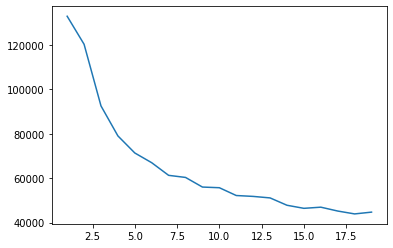

In [246]:
# step1 : run pca again on the selected features and then clustering
from customerclustering.trainer_pca import *
col_select=['account_age','docPerYear','docOnAusmedPerYear',
            'minPerYear','minOnAusmedPerYear',
            'numQueuedPerYear','minQueuedPerYear',
            'numCompletedOnelinePerYear','minCompletedOnelinePerYear',
            'event_cpd_day_diff','doc_in_activation','GoalsPerYear','activated',
            'learnFromAusmedRatio_num','hasPracticeRecord','located','access','autonomy','complex']

df_filter=df[col_select]


# preprocess 
preproc=Trainer(df,'mdoel_v0',run_tsne=False).preprocessing()
df_processed=preproc.fit_transform(df_filter)
df_processed=pd.DataFrame(df_processed,columns=col_select)


pca=PCA()

df_proj=pd.DataFrame(pca.fit_transform(df_processed),columns=[f'PC{i}' for i in range(1, len(df_processed.columns)+1)])
df_proj
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_proj).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss); # same as with pca!!!!

In [200]:
v0_W = pca.components_

# Print PCs as COLUMNS
v0_W = pd.DataFrame(v0_W.T,
                 index=df_filter.columns,
                 columns=[f'PC{i}' for i in range(1, len(df_filter.columns)+1)])

v0_W.style.applymap(lambda x: "background-color: yellow" if abs(x)>0.1 else "background-color: white")
# select top 5 factors dominating the first three PCs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
account_age,0.030912,-0.006231,0.044141,0.017504,0.200290,0.100170,0.065931,-0.455687,0.327399,-0.775241,-0.084874,0.125992,0.041565,0.023558,-0.031985,-0.005617,0.000000,0.000000,0.000000
docPerYear,0.052005,0.141594,-0.145852,0.363418,0.229869,0.116756,-0.259654,0.256968,-0.395249,-0.157185,-0.517025,0.264215,-0.088436,0.003451,-0.282876,-0.134431,0.000000,0.000000,0.000000
docOnAusmedPerYear,-0.066985,0.151286,-0.227046,0.365483,-0.180408,-0.160215,-0.298778,0.136064,-0.245038,-0.366040,0.408953,-0.096705,-0.023023,-0.004802,0.424217,0.265259,0.000000,0.000000,0.000000
minPerYear,0.975332,-0.084053,-0.162410,-0.028194,-0.098969,-0.030207,0.014121,0.007266,-0.011749,-0.016102,0.054153,-0.013870,-0.001122,-0.002424,-0.000990,0.000515,0.000000,0.000000,0.000000
minOnAusmedPerYear,-0.018357,0.153994,-0.203684,0.318346,-0.317881,-0.281021,-0.356871,-0.453585,0.361305,0.313387,-0.262700,0.087516,0.112439,-0.002675,-0.002500,-0.043827,0.000000,0.000000,0.000000
numQueuedPerYear,-0.026959,0.314070,-0.338636,-0.463459,0.127114,0.092896,-0.245906,-0.021968,-0.048962,0.010758,0.062647,0.008814,0.422815,0.037618,-0.310483,0.449802,0.000000,0.000000,0.000000
minQueuedPerYear,-0.023610,0.297344,-0.322026,-0.435105,0.118160,0.078345,-0.206997,-0.057005,-0.019479,-0.008680,0.015616,-0.001856,-0.221356,-0.017735,0.374591,-0.601234,0.000000,0.000000,0.000000
numCompletedOnelinePerYear,-0.047690,0.250768,-0.328356,0.203864,-0.093846,-0.100187,0.597413,0.234876,0.092834,-0.067113,-0.021666,0.031979,0.513451,0.025537,0.041410,-0.271913,0.000000,0.000000,0.000000
minCompletedOnelinePerYear,-0.040849,0.284165,-0.343016,-0.027399,-0.075171,-0.068406,0.388540,0.025112,0.154931,0.006775,-0.138232,-0.024863,-0.670853,-0.041717,-0.100716,0.362689,0.000000,0.000000,0.000000
event_cpd_day_diff,0.017555,-0.037817,0.059255,-0.040622,0.061077,-0.084844,-0.295967,0.652005,0.670459,-0.117365,-0.064514,-0.037591,-0.019598,-0.013821,-0.004030,0.002820,0.000000,0.000000,0.000000


In [202]:
# top features to put in 
col_select1=['minPerYear','GoalsPerYear','numQueuedPerYear',
             'minCompletedOnelinePerYear','doc_in_activation','docPerYear','activated']

# save the list
with open("../raw_data/features_4_frontend.txt", 'w') as f:
    for s in col_select1:
        f.write(str(s) + '\n')

In [206]:
label=MiniBatchKMeans(n_clusters=15).fit_predict(df_proj)
df_filter['label']=label
df_processed.describe()

/var/folders/bh/j223y_td6s35mkxwj_m8bxdm0000gn/T/ipykernel_40461/2070993917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['label']=label


,account_age,docPerYear,docOnAusmedPerYear,minPerYear,minOnAusmedPerYear,numQueuedPerYear,minQueuedPerYear,numCompletedOnelinePerYear,minCompletedOnelinePerYear,event_cpd_day_diff,doc_in_activation,GoalsPerYear,activated,learnFromAusmedRatio_num,hasPracticeRecord,located,access,autonomy,complex
count,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7.420000e+03,7.420000e+03,7420.000000,7420.000000,7420.000000,7420.000000,7420.000000,7420.0,7420.0,7420.000000,7420.0
mean,-0.133696,0.243825,-0.112343,0.657589,0.297198,0.375184,0.341366,0.289536,2.738996e-01,1.953059e-02,0.421698,0.995672,0.696631,0.556131,0.901078,0.0,0.0,-0.057817,0.0
std,0.586480,0.799348,0.842932,2.356227,0.896761,1.079928,1.016116,0.970290,9.019286e-01,6.657301e-01,0.939591,1.841837,0.459744,0.408887,0.298577,0.0,0.0,0.853479,0.0
min,-1.690483,-0.333333,-1.000000,-0.612585,-0.376344,-0.500000,-0.486951,-0.659341,-6.845436e-01,-1.228582e+00,-0.333333,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-2.000000,0.0
25%,-0.582852,-0.333333,-1.000000,-0.289757,-0.376344,-0.325000,-0.343410,-0.362637,-3.646427e-01,-5.033172e-01,-0.333333,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000,0.0
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.507571e-17,1.235584e-16,0.000000,0.000000,1.000000,0.500000,1.000000,0.0,0.0,0.000000,0.0
75%,0.417148,0.666667,0.000000,0.710243,0.623656,0.675000,0.656590,0.637363,6.353573e-01,4.966828e-01,0.666667,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.000000,0.0
max,0.674977,11.666667,12.000000,34.318056,9.543011,11.000000,10.299478,12.461538,9.659347e+00,1.918181e+00,14.000000,21.500000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,0.0


Text(0, 0.5, 'log(GoalsPerYear)')

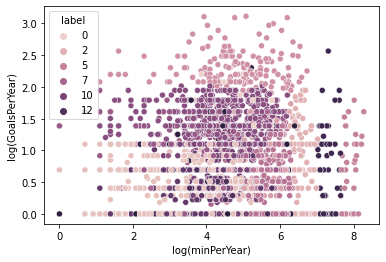

In [228]:
sns.scatterplot(x=np.log(df_filter.minPerYear),y=np.log(df_filter.GoalsPerYear),hue=df_filter.label)
plt.xlabel('log(minPerYear)')
plt.ylabel('log(GoalsPerYear)')

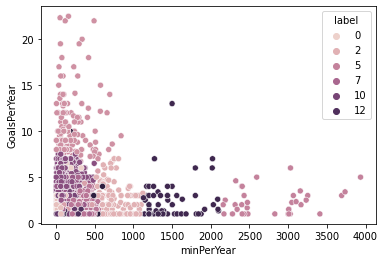

In [229]:
sns.scatterplot(x=df_filter.minPerYear,y=df_filter.GoalsPerYear,hue=df_filter.label)
plt.xlabel('minPerYear')
plt.ylabel('GoalsPerYear')
df_filter.to_csv('../raw_data/data_withlable_pca.csv')

In [230]:
df_filter.groupby('label').mean()

,account_age,docPerYear,docOnAusmedPerYear,minPerYear,minOnAusmedPerYear,numQueuedPerYear,minQueuedPerYear,numCompletedOnelinePerYear,minCompletedOnelinePerYear,event_cpd_day_diff,doc_in_activation,GoalsPerYear,activated,learnFromAusmedRatio_num,hasPracticeRecord
label,,,,,,,,,,,,,,,
0,1142.650000,3.770513,3.376960,169.290549,133.286300,28.646154,1305.494359,75.868205,5912.427179,147.984088,6.661538,3.116667,0.984615,0.883140,0.830769
1,1451.900461,1.163318,0.533942,54.224797,12.723637,3.190688,139.876440,6.701685,529.035927,158.374118,2.017617,1.326105,0.476091,0.496039,0.908138
2,1565.153285,2.047178,0.348723,753.900552,18.245191,5.266777,235.075497,7.646358,713.765894,171.154962,4.132450,2.393057,0.807947,0.156756,0.933775
3,1586.824219,2.805073,1.870132,199.658121,105.960280,8.798079,402.113559,18.958418,1585.235650,132.321214,7.420339,1.886174,0.993220,0.672371,0.949153
4,1494.376068,1.963249,0.758864,185.311794,33.347709,8.015054,358.960215,13.888280,1284.149140,151.612565,5.503226,10.542320,0.858065,0.406187,0.903226
5,1662.875000,1.831156,0.392993,2799.086939,14.385510,4.986667,230.783810,10.201905,822.573810,155.326236,4.600000,2.385714,0.857143,0.208512,0.971429
6,1643.734375,1.579961,0.241516,333.341060,8.746549,4.035616,189.326224,6.638683,612.020399,157.881833,3.517832,1.489079,0.774608,0.145166,0.957204
7,1366.468992,2.705758,2.410489,100.747655,76.915411,5.320606,231.791273,47.988545,2901.026242,115.767122,6.963636,1.557506,0.992727,0.890311,0.858182
8,1481.253731,1.438318,0.733346,85.790383,21.969901,16.478874,759.522857,15.191039,1765.852727,140.174910,3.005195,2.793961,0.727273,0.526584,0.940260


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(PC2)')

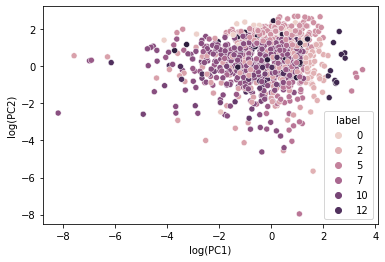

In [249]:
#plot project data

df_proj['label']=label
sns.scatterplot(x=np.log(df_proj.PC1),y=np.log(df_proj.PC2),hue=df_proj.label)
plt.xlabel('log(PC1)')
plt.ylabel('log(PC2)')
#df_proj.to_csv('../raw_data/projected_data_withlable_pca.csv')

Text(0, 0.5, 'PC2')

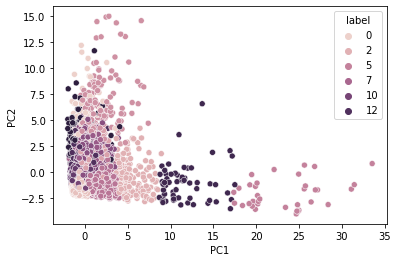

In [250]:
sns.scatterplot(x=df_proj.PC1,y=df_proj.PC2,hue=df_proj.label)
plt.xlabel('PC1')
plt.ylabel('PC2')


## PCA+DBSCAN

In [321]:
from customerclustering.trainer_pca import *
from sklearn.cluster import DBSCAN
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

trainer=Trainer(df,'testing',clustering_model='kmeans')
df=trainer.df

#get processed data
df_processed=trainer.get_processed_data()
total_num_features = df_processed.shape[1]

pca_pipe = make_pipeline(preproc,
                         PCA(11))


dbscan=DBSCAN()
dbscan.fit(pca_pipe.fit_transform(df))


the percentage of outliers disgarded is 0.09502806736166802
 
--- robust ---
account_age
docPerYear
docOnAusmedPerYear
event_cpd_day_diff
subscribe_days
GoalsPerYear
 
--- minmax ---
num_subs
activated
hasPracticeRecord
learnFromAusmedRatio_num
learnFromAusmedRatio_min
ratioOfAchivedGoals
 
--- log ---
minPerYear
minOnAusmedPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation
 
--- ordinal ---
plan_type
complex
Status
access
autonomy
located


DBSCAN()

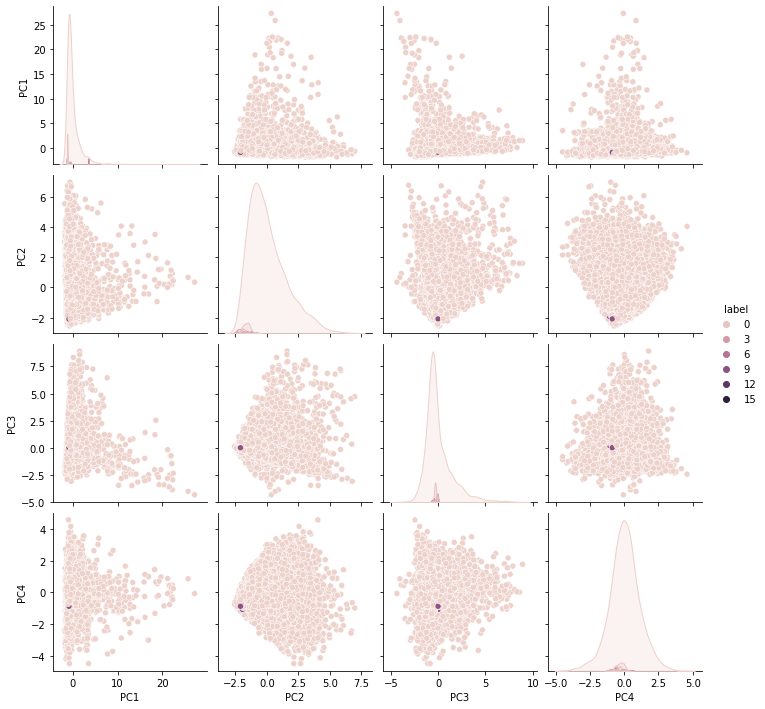

In [322]:
# visualizing the data
import seaborn as sns
labels=dbscan.labels_
df_proj=pd.DataFrame(pca_pipe.fit_transform(df),columns=[f'PC{i}' for i in range(1,11+1)])
df_proj['label']=labels
df['label']=labels
#df_processed['label']=labels
sns.pairplot(df_proj[['PC1', 'PC2', 'PC3', 'PC4', 'label']], hue = 'label');

#sns.pairplot(df_processed, hue = 'label');

## Test trainer 

/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have a high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('be generally complex','generally complex',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

Kmeans is use for clustering with 6 clusters
the model fitted


/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_pca.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['label']=self.labels


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

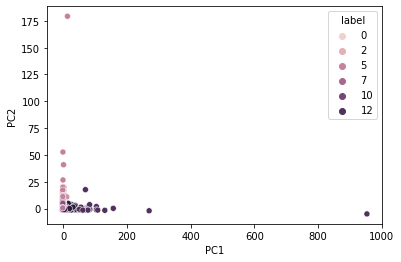

In [258]:
import seaborn as sns
import matplotlib.pyplot as plt
from customerclustering.trainer_pca import *
from sklearn.decomposition import PCA
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df.head()

trainer=Trainer(df,'model_v0')


trainer.run(n_cluster=6)
df_proj=trainer.df_proj
#sns.scatterplot(x=df_proj.minCompleted,y=df_proj.minPerYear,hue=df_proj.label)
sns.scatterplot(x=df_proj.PC1,y=df_proj.PC2,hue=df_proj.label)
 # we have oustanding outliers in both x and y axes
    
 # we have oustanding outliers in both x and y axes    

In [134]:
trainer.W#.style.applymap(lambda x: "background-color: yellow" if abs(x)>0.1 else "background-color: white")
# investigate the first 5 PCs
trainer.W.iloc[:,:5]

,PC1,PC2,PC3,PC4,PC5
num_subs,0.000841,-0.005611,0.004169,0.011250,0.045579
account_age,0.001842,0.036901,-0.052010,0.030608,0.014883
docPerYear,0.000336,0.046601,0.010272,0.077322,0.293675
docOnAusmedPerYear,0.001595,-0.079643,0.066459,0.037204,0.371315
minPerYear,-0.004165,0.971834,0.158361,-0.089314,0.048154
minOnAusmedPerYear,0.001547,-0.038164,0.068504,0.059253,0.361736
learnFromAusmedRatio_min,0.001005,-0.084717,0.043994,-0.005121,0.115591
numQueued,0.011729,-0.009579,-0.038136,0.117482,0.452965
numCompletedFromQueue,0.027481,-0.009892,0.002275,-0.001689,0.038201
minQueued,0.010585,-0.007583,-0.038762,0.114379,0.439829


## Test trainer (version after Alec)

In [323]:
from customerclustering.trainer_pca import *
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

trainer=Trainer(df,'model_v1',clustering_model='kmeans')
df=trainer.df
trainer.run(best_num_pcs=11,best_num_clusters=6)


the percentage of outliers disgarded is 0.09502806736166802
 
--- robust ---
account_age
docPerYear
docOnAusmedPerYear
event_cpd_day_diff
subscribe_days
GoalsPerYear
 
--- minmax ---
num_subs
activated
hasPracticeRecord
learnFromAusmedRatio_num
learnFromAusmedRatio_min
ratioOfAchivedGoals
 
--- log ---
minPerYear
minOnAusmedPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation
 
--- ordinal ---
plan_type
complex
Status
access
autonomy
located

 --- got preprocessed data 
 
 --- pca fitted 

 --- got weights 

 --- Kmeans is use for clustering with 6 clusters

 --- Kmean model fitted 

 --- the top 10 features are--- 
docPerYear
docOnAusmedPerYear
GoalsPerYear
learnFromAusmedRatio_min
minPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation

 they are saved as the important_features attribute 


In [325]:
trainer.save_model()

pca+kmeans model,model_v1_withpca.joblib and data with labels saved locally


In [292]:
#get best_num_pcs
def plot_pca_results(pca_results, num_pcs = None):
    
    # get explained variance of each PC
    explained_variance = pca_results.explained_variance_

    # plot explained variance for elbow plot
    plt.plot(explained_variance)
    plt.xlabel('# PCS')
    if num_pcs:
        plt.scatter(num_pcs, explained_variance[num_pcs], c = 'r');
  



 
--- robust ---
account_age
docPerYear
docOnAusmedPerYear
event_cpd_day_diff
subscribe_days
GoalsPerYear
 
--- minmax ---
num_subs
activated
hasPracticeRecord
learnFromAusmedRatio_num
learnFromAusmedRatio_min
ratioOfAchivedGoals
 
--- log ---
minPerYear
minOnAusmedPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation
 
--- ordinal ---
plan_type
complex
Status
access
autonomy
located


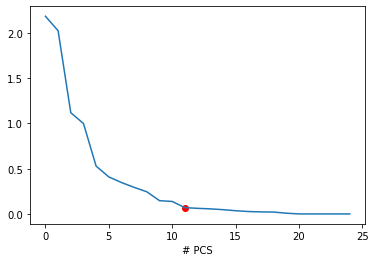

In [296]:
df_processed=trainer.get_processed_data()
total_num_features = df_processed.shape[1]

pca_pipe = make_pipeline(preproc,
                         PCA(total_num_features))

pca=PCA()
# process the dataframe and save back into dataframe
pcs_plot_df = pd.DataFrame(pca.fit_transform(df_processed),
                           columns = [f'PC{i + 1}' for i in range(total_num_features)])

plot_pca_results(pca_results = pca, 
                 num_pcs = 11)

# "looks like ~12 pcs explain a good amount of the variation?" (Alec)
# it looks 11 is good with the updated data
best_num_pcs = 11



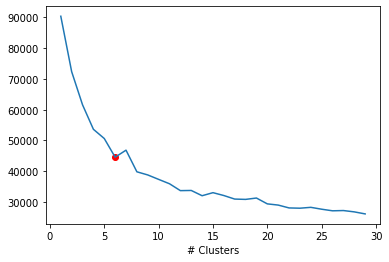

In [302]:
# find the optimal n_cluster with elbow method
# will change a little bit each time because of mini batches

inertia_list = []

clusters = list(range(1, 30))

for k in clusters:
    
    kmeans_elbow = make_pipeline(preproc, 
                                 PCA(best_num_pcs),
                                 MiniBatchKMeans(n_clusters = k)).fit(df)
    
    inertia_list.append(kmeans_elbow[-1].inertia_)
    
plt.plot(clusters, inertia_list);
plt.xlabel('# Clusters')

n_clusters = 6
plt.scatter(n_clusters, inertia_list[n_clusters - 1], c = 'r');

# looks like ~4 to ~8 clusters is best? 
best_num_clusters = 6

In [319]:
trainer.run(best_num_pcs=11,best_num_clusters=6)
trainer.save_model()

 
--- robust ---
account_age
docPerYear
docOnAusmedPerYear
event_cpd_day_diff
subscribe_days
GoalsPerYear
 
--- minmax ---
num_subs
activated
hasPracticeRecord
learnFromAusmedRatio_num
learnFromAusmedRatio_min
ratioOfAchivedGoals
 
--- log ---
minPerYear
minOnAusmedPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation
 
--- ordinal ---
plan_type
complex
Status
access
autonomy
located

 --- got preprocessed data 
 
 --- pca fitted 

 --- got weights 

 --- Kmeans is use for clustering with 6 clusters

 --- Kmean model fitted 
pca+kmeans model,model_v1_withpca.joblib and data with labels saved locally


## look at each clusters

In [12]:
from scipy import stats
import pandas as pd

cluster_centers_top_feat=pd.read_csv('../raw_data/model_v1_cluster_centers.csv',index_col=[0])


def zscore_df(df):
    return df.apply(lambda col: stats.zscore(col))

df_interest = zscore_df(cluster_centers_top_feat)
#cluster_centers_top_feat

,docPerYear,docOnAusmedPerYear,GoalsPerYear,learnFromAusmedRatio_min,minPerYear,numQueuedPerYear,numCompletedOnelinePerYear,minCompletedOnelinePerYear,minQueuedPerYear,doc_in_activation
0,0.803480,0.418019,0.450567,0.634192,0.242721,0.301354,0.494607,0.513845,0.235347,0.583178
1,-0.196292,0.000985,0.376819,0.843528,-0.840625,0.197921,0.021531,0.032594,0.089694,-0.281006
2,0.176543,-0.287589,0.403323,0.449052,-0.056404,-1.096237,-0.355420,-0.930397,-1.902682,0.148423
3,0.294335,-0.508630,5.547408,0.242124,0.340462,-0.452103,-0.401147,-0.641401,-0.938997,0.343604
4,0.113097,-0.889990,0.585947,0.036037,0.510679,0.007854,-0.506519,-0.483573,-0.151900,0.100009
5,0.326808,-0.204436,3.613830,0.427692,0.188317,0.332129,0.143126,0.245134,0.276302,0.359861


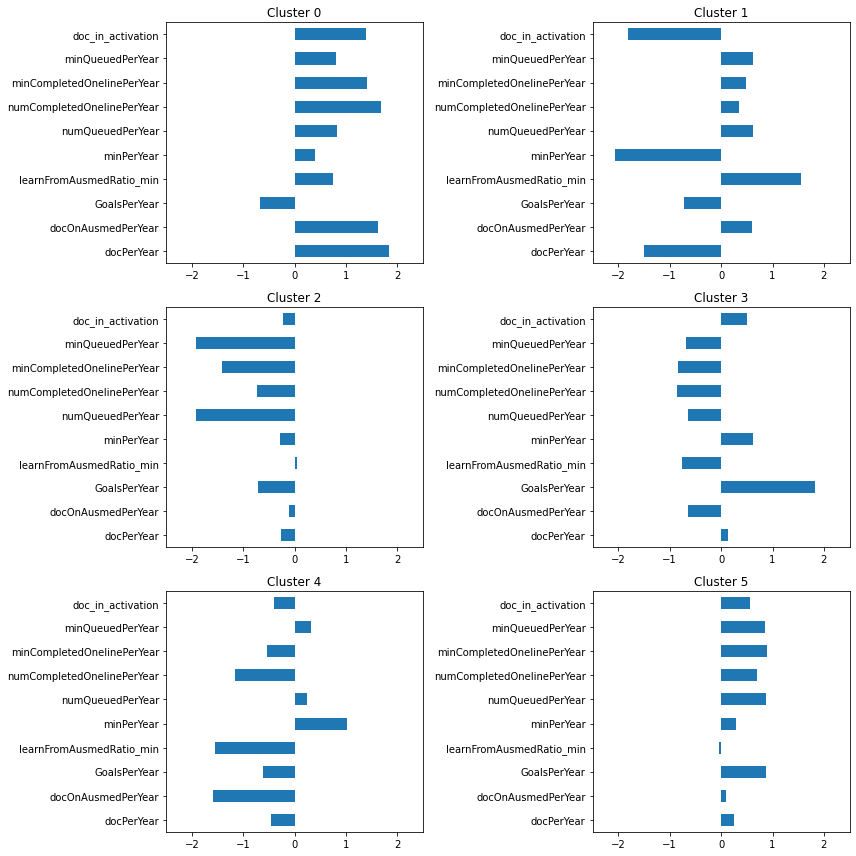

In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize = (12, 12))
cluster_ids=range(6)

for ax, cluster_id in zip(axes.flat, cluster_ids):
    df_interest.iloc[cluster_id, :].plot(kind = 'barh', ax = ax)
    ax.set_title(f'Cluster {cluster_id}')
    ax.set_xlim((-2.5, 2.5))
    
plt.tight_layout()

# plt.savefig('cluster_comparison.png', facecolor = 'white')

In [10]:
# save data for the frontend (this is also included in the lastest trainer)
import pandas as pd
import joblib
df0=pd.read_csv('../raw_data/model_v1_labeled_data.csv',index_col=[0])
df1=pd.read_csv('../raw_data/model_v1_cluster_centers.csv',index_col=[0])
select_cols=['userID']+list(df1.columns)+['cluster_id']

df3=df0.loc[:, select_cols]
#df3.to_csv('../raw_data/model_v1_frontend_data.csv')

## Version 2: include account years and subscribe_days

In [26]:
from customerclustering.trainer_pca import *
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

trainer=Trainer(df,'model_v3',clustering_model='kmeans')
df=trainer.df
trainer.run(best_num_pcs=11,best_num_clusters=6)


the percentage of outliers disgarded is 0.09502806736166802
 
--- robust ---
account_age
docPerYear
docOnAusmedPerYear
event_cpd_day_diff
subscribe_days
GoalsPerYear
 
--- minmax ---
num_subs
activated
hasPracticeRecord
learnFromAusmedRatio_num
learnFromAusmedRatio_min
ratioOfAchivedGoals
 
--- log ---
minPerYear
minOnAusmedPerYear
numQueuedPerYear
numCompletedOnelinePerYear
minCompletedOnelinePerYear
minQueuedPerYear
doc_in_activation
 
--- ordinal ---
autonomy
located
plan_type
Status
complex
access

 --- got preprocessed data 
 
 --- pca fitted 

 --- got weights 

 --- Kmeans is use for clustering with 6 clusters

 --- Kmean model fitted 

 --- the top 10 features are--- 
minPerYear
doc_in_activation
minQueuedPerYear
GoalsPerYear
account_age
numCompletedOnelinePerYear
docPerYear
numQueuedPerYear
minCompletedOnelinePerYear
docOnAusmedPerYear
learnFromAusmedRatio_min
subscribe_days

 they are saved as the important_features attribute 


In [27]:
trainer.save_model()

pca+kmeans model,model_v3_withpca.joblib and data with labels saved locally


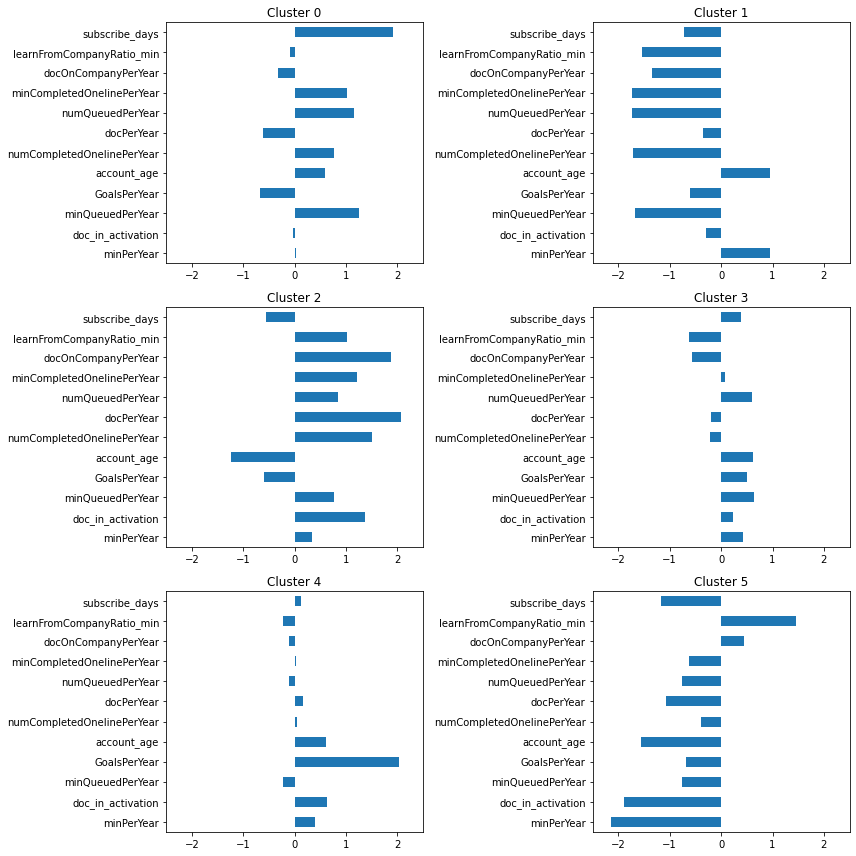

In [43]:
# visualizing
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

cluster_centers_top_feat=pd.read_csv('../raw_data/model_v3_cluster_centers.csv',index_col=[0])
cluster_centers_top_feat.rename(columns={'docOnAusmedPerYear':'docOnCompanyPerYear', 
                                         'learnFromAusmedRatio_min':'learnFromCompanyRatio_min'},
                               inplace=True)

def zscore_df(df):
    return df.apply(lambda col: stats.zscore(col))

df_interest = zscore_df(cluster_centers_top_feat)

# mask Ausmed's name



fig, axes = plt.subplots(3, 2, figsize = (12, 12))
cluster_ids=range(6)

for ax, cluster_id in zip(axes.flat, cluster_ids):
    df_interest.iloc[cluster_id, :].plot(kind = 'barh', ax = ax)
    ax.set_title(f'Cluster {cluster_id}')
    ax.set_xlim((-2.5, 2.5))
    
plt.tight_layout()
plt.savefig('cluster_comparison.png', facecolor = 'white')

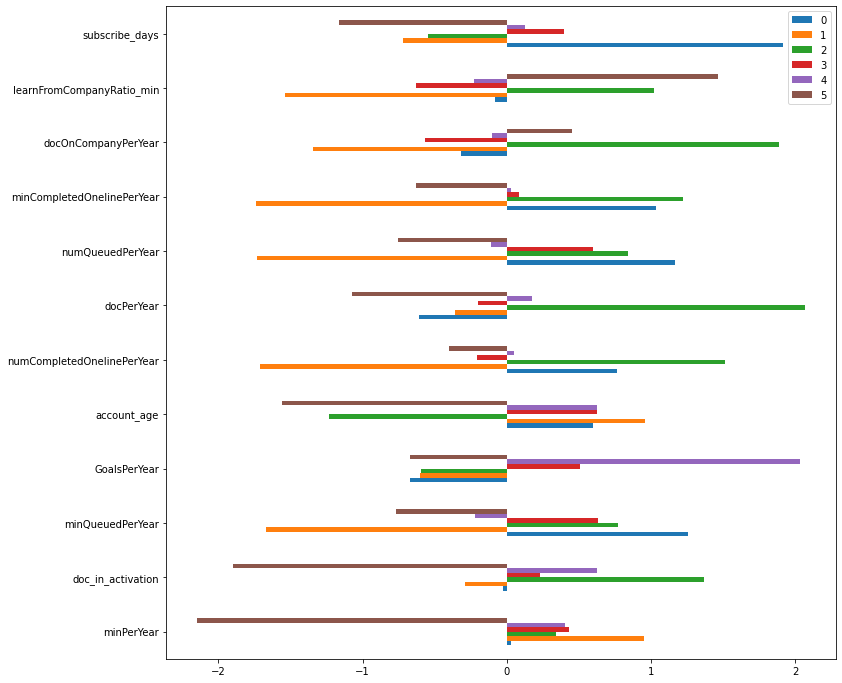

In [44]:
df_interest = zscore_df(cluster_centers_top_feat)
fig, ax = plt.subplots(figsize = (12, 12))

df_interest.T.plot(kind = 'barh', ax = ax);

plt.savefig('feature_comparison.png', facecolor = 'white')

## Investigate clusters


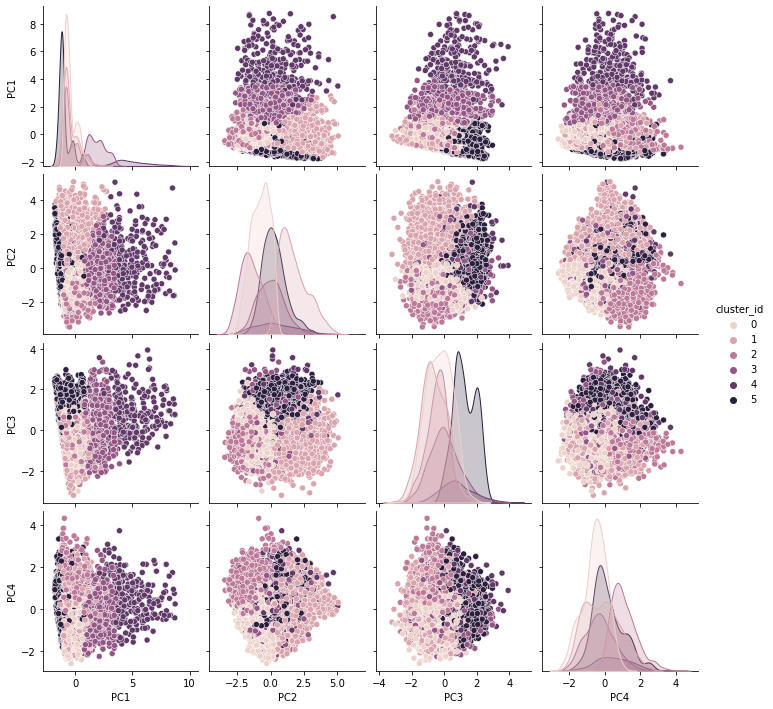

In [35]:
# visualise first 4 PCs in 2D
import seaborn as sns
pcs_df=trainer.df_proj
#pcs_df.to_csv('../raw_data/model_v3_projected_data.csv')
sns.pairplot(pcs_df[['PC1', 'PC2', 'PC3', 'PC4', 'cluster_id']], hue = 'cluster_id');
plt.savefig('PC_comparison.png', facecolor = 'white')

## cluster size

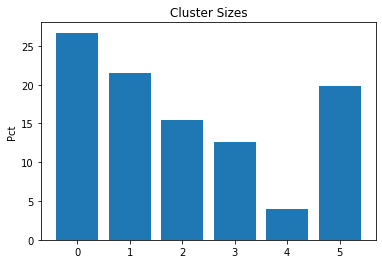

In [40]:
# check counts in each cluster
cluster_ids, cluster_counts = np.unique(trainer.labels, return_counts = True)

# plot counts
plt.bar(cluster_ids, cluster_counts / cluster_counts.sum() * 100)
plt.title('Cluster Sizes')
plt.ylabel('Pct');
plt.savefig('cluster_size.png', facecolor = 'white')

## old testing

/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('be generally complex','generally complex',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats

PCA is not included
MiniKmeans fitted


<AxesSubplot:xlabel='minCompletedFromQueue', ylabel='minPerYear'>

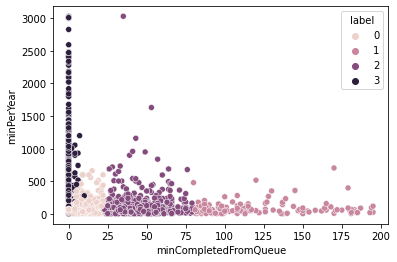

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from customerclustering.trainer_v0 import *
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])
df.head()

trainer=Trainer(df,'model_v0',run_pca=False)
trainer.run(n_cluster=4)
df_proj=trainer.df_proj
sns.scatterplot(x=df_proj.minCompletedFromQueue,y=df_proj.minPerYear,hue=df_proj.label)
#sns.scatterplot(x=df_proj.PC1,y=df_proj.PC2,hue=df_proj.label)
 # we have oustanding outliers in both x and y axes

In [48]:
pd.DataFrame(trainer.pipe['kmeans'].cluster_centers_,columns=

array([[ 1.18102706e-01, -2.09437125e-01,  2.41955112e-01,
        -2.32904669e-02,  3.85105599e-02,  3.70406686e-01,
         2.18749696e-01,  2.75008766e-01,  1.85330401e-01,
         2.72997329e-01,  1.10426827e+00,  5.90061018e-03,
         2.93073220e-01,  3.80411158e-02,  6.38225085e-01,
         6.52417838e-01,  4.08000007e-02,  6.50936832e-01,
         6.29356798e-03,  8.73609384e-01,  1.80160351e-02,
         6.29356798e-03, -5.02066665e-01, -4.44208027e-01,
        -9.88078161e-01, -6.80883619e-02, -1.55270791e-01,
         9.65860189e-03],
       [ 1.38164251e-01,  7.38266356e-02,  1.66924316e-01,
        -5.89694042e-02,  1.68994597e-01,  3.75874038e-01,
         2.22354534e-01,  1.34599034e+00,  2.85410628e+00,
         1.25403391e+00,  1.14475362e+02, -1.50938870e-01,
         4.59259259e-01,  2.48723410e-01,  1.25119163e+00,
         7.56521739e-01,  5.12265351e-02,  6.67794439e-01,
         1.14638734e-01,  9.14009662e-01,  1.15813108e-01,
         1.14638734e-01, -4.21

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log(minPerYear)')

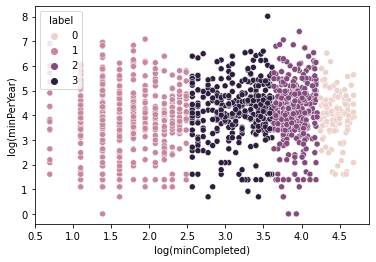

In [21]:
# plot with log axes
sns.scatterplot(x=np.log(df_proj.minCompleted),y=np.log(df_proj.minPerYear),hue=df_proj.label)
plt.xlabel('log(minCompleted)')
plt.ylabel('log(minPerYear)')

In [26]:
trainer.save_model()

Just kmeans,model_v0_nopca.joblib                          saved locally


# Refine preprocessing 

num_subs


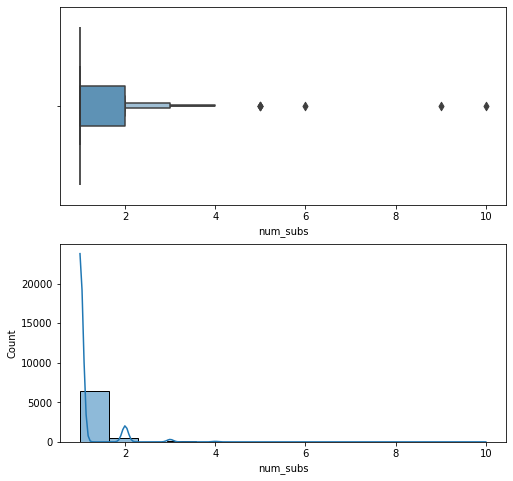

account_age


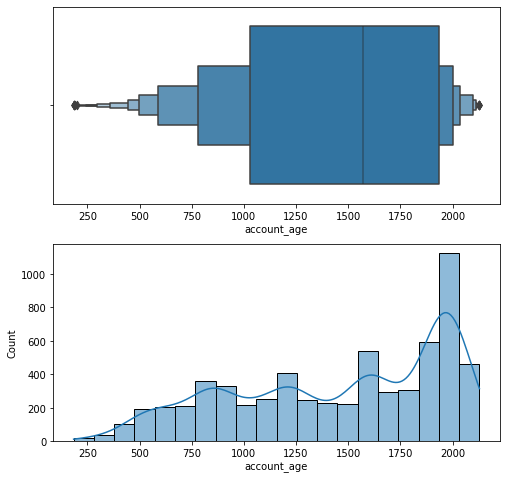

hasPracticeRecord


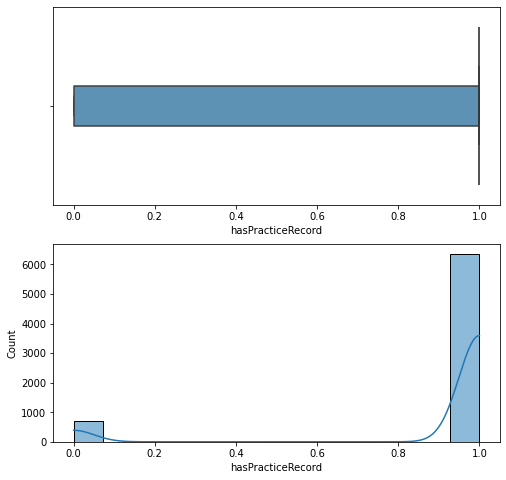

docPerYear


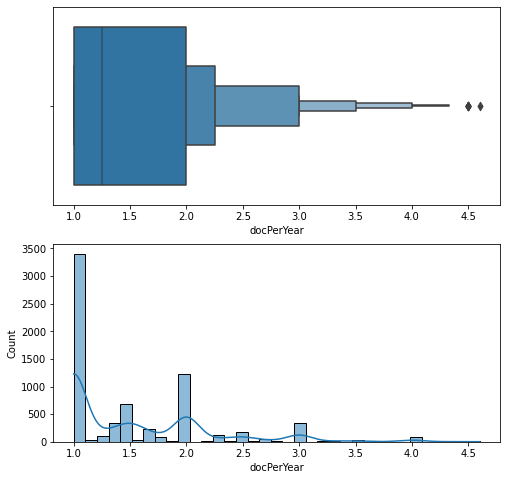

docOnAusmedPerYear


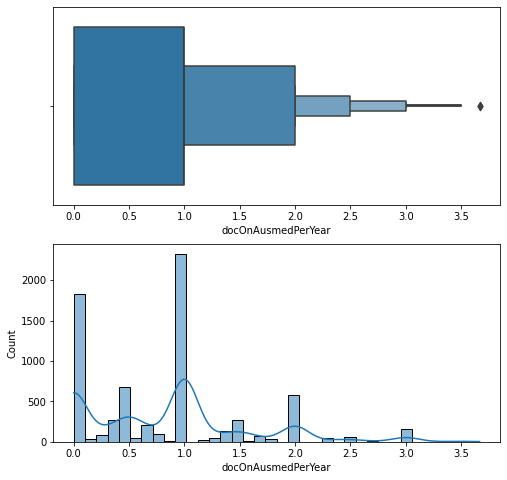

minPerYear


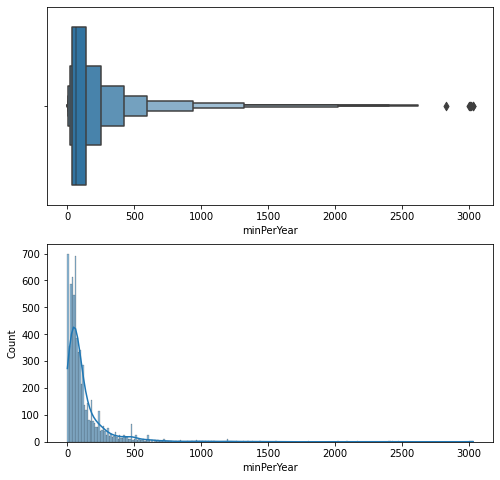

minOnAusmedPerYear


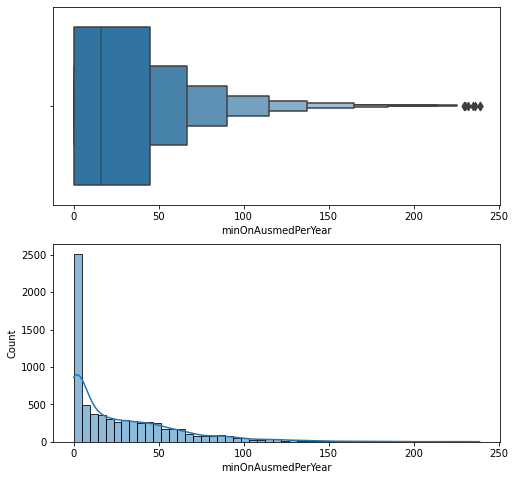

learnFromAusmedRatio_num


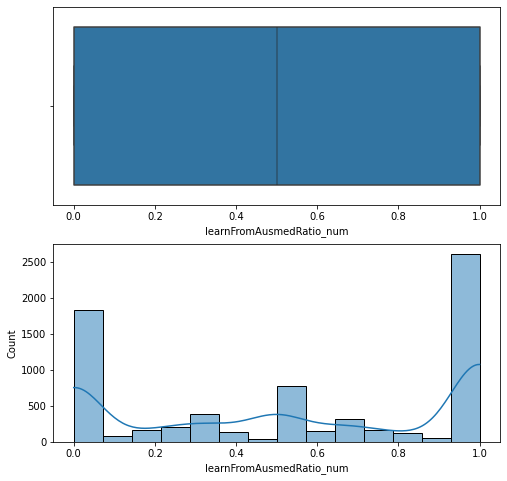

learnFromAusmedRatio_min


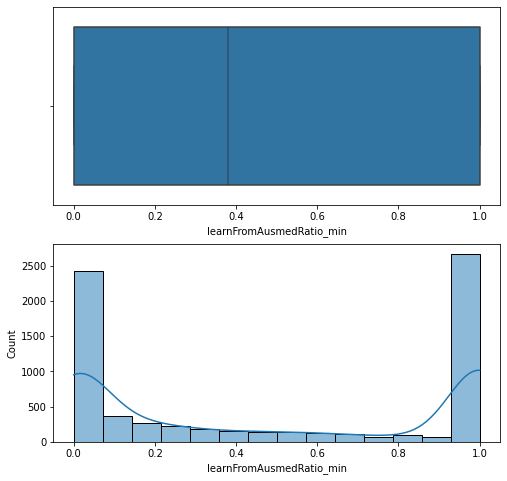

numQueued


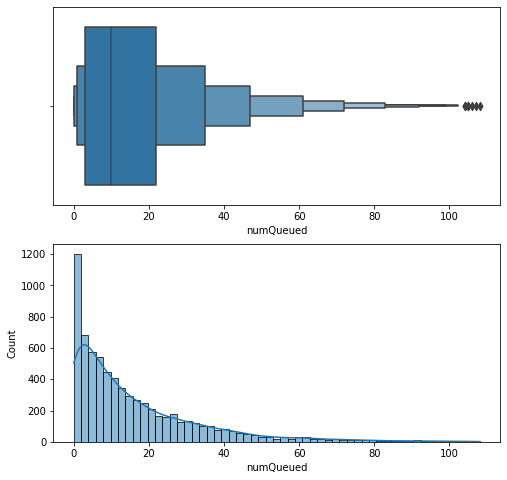

numCompletedFromQueue


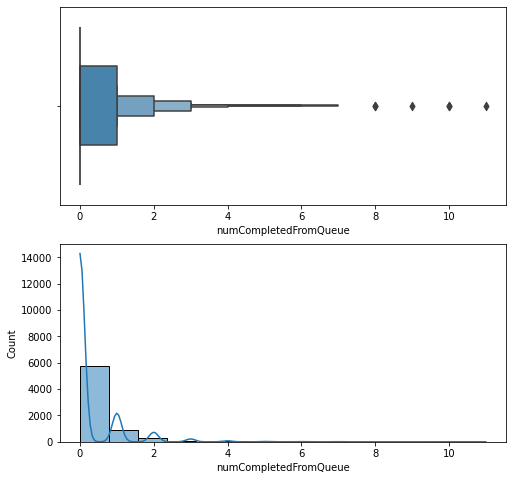

minQueued


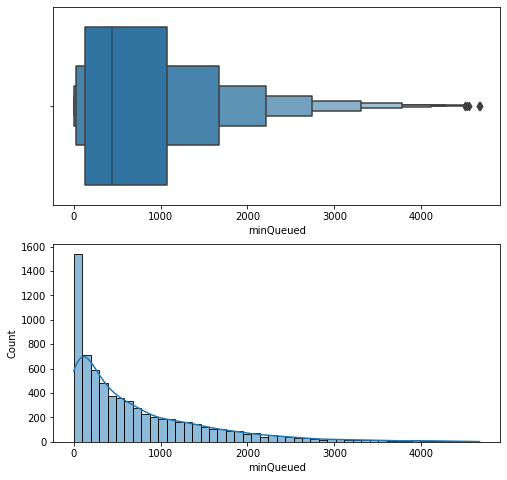

minCompleted


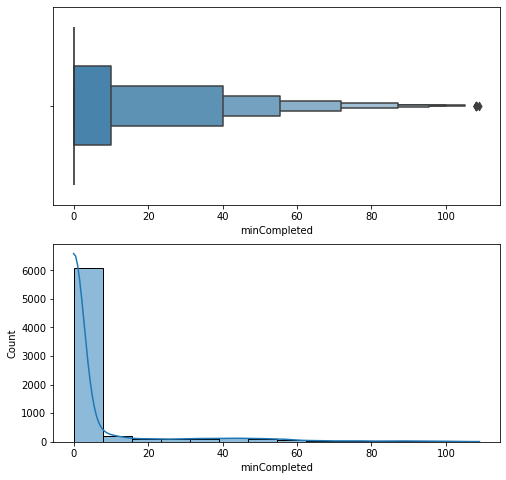

RatioOfCompletion_num


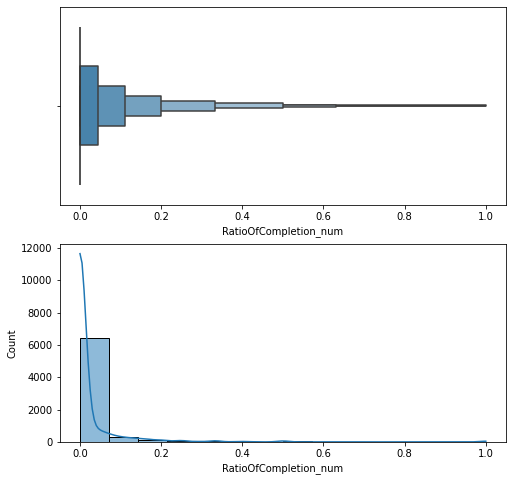

RatioOfCompletion_min


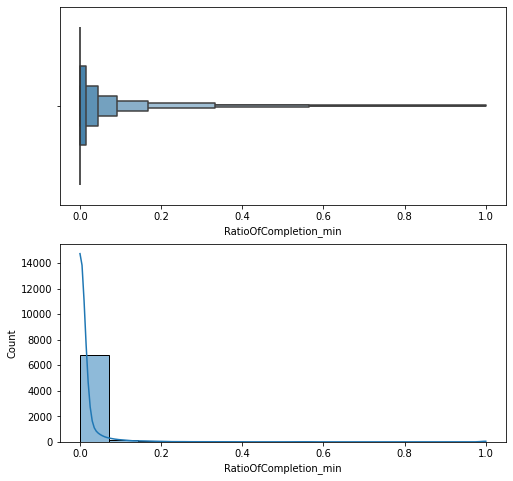

event_cpd_day_diff


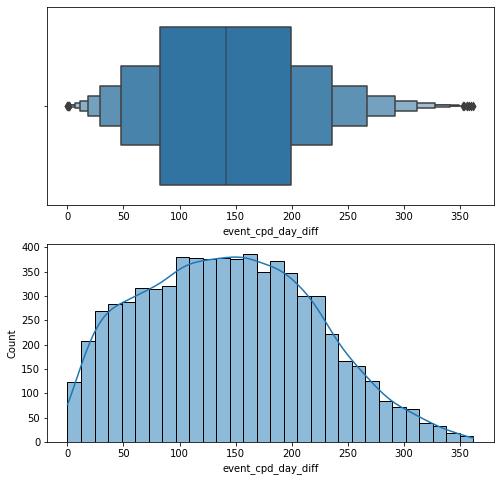

doc_in_activation


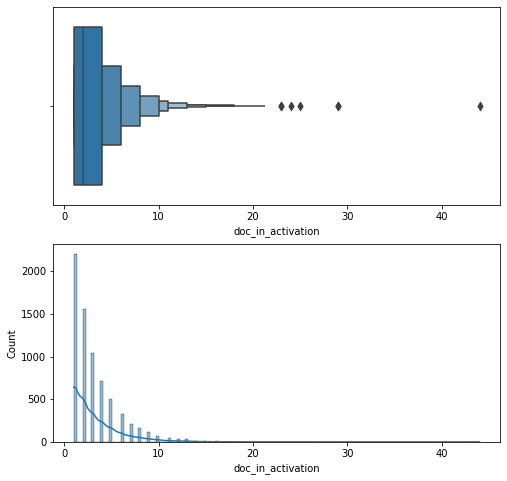

activated


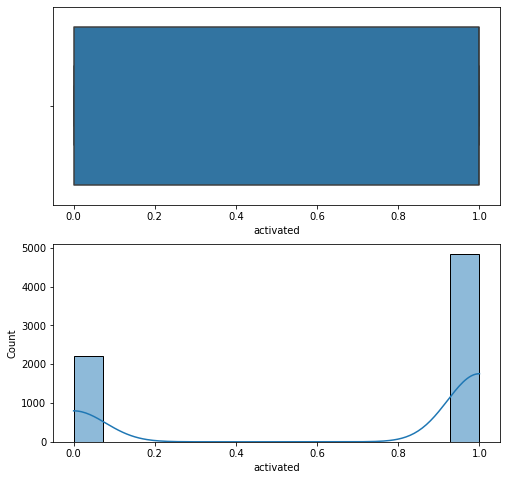

subscribe_days


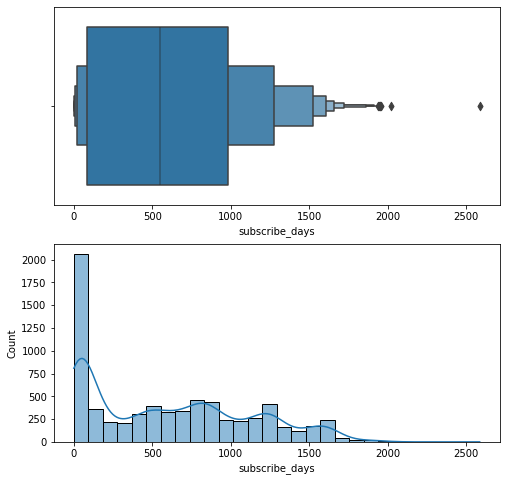

GoalsPerYear


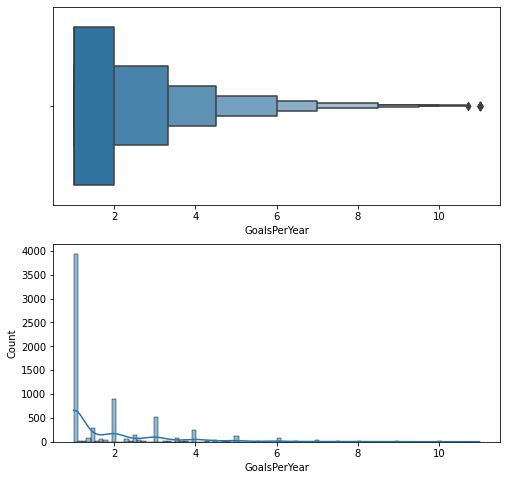

ratioOfAchivedGoals


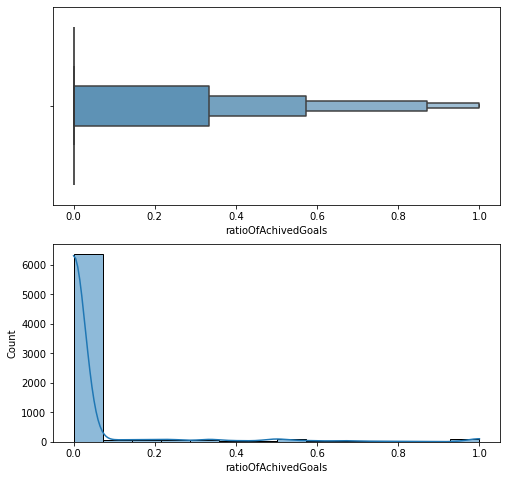

In [10]:
# plot the numerical columns and check again
import matplotlib.pyplot as plt
import seaborn as sns
#col_inuse=[feature for feature in  df.describe().columns if feature not in col_not_inuse]

for feature in df_cleaned.describe():
    print(feature)
    fig, ax=plt.subplots(2, figsize=(8,8))
    sns.boxenplot(x=df_cleaned[f'{feature}'],ax=ax[0])
    sns.histplot(x=df_cleaned[f'{feature}'],kde=True,ax=ax[1])
    plt.show()

In [11]:
df_cleaned.describe().columns

Index(['num_subs', 'account_age', 'hasPracticeRecord', 'docPerYear',
       'docOnAusmedPerYear', 'minPerYear', 'minOnAusmedPerYear',
       'learnFromAusmedRatio_num', 'learnFromAusmedRatio_min', 'numQueued',
       'numCompletedFromQueue', 'minQueued', 'minCompleted',
       'RatioOfCompletion_num', 'RatioOfCompletion_min', 'event_cpd_day_diff',
       'doc_in_activation', 'activated', 'subscribe_days', 'GoalsPerYear',
       'ratioOfAchivedGoals'],
      dtype='object')

['num_subs', 'account_age', 'docPerYear', 'docOnAusmedPerYear', 'minPerYear', 'minOnAusmedPerYear', 'learnFromAusmedRatio_min', 'numQueued', 'numCompletedFromQueue', 'minQueued', 'minCompleted', 'event_cpd_day_diff', 'doc_in_activation', 'subscribe_days', 'GoalsPerYear']


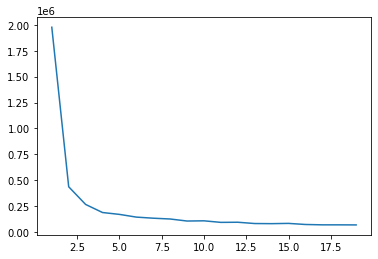

In [33]:
# rom sklearn.preprocessing import RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer,make_column_transformer
from sklearn import set_config; set_config(display='diagram')
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder,RobustScaler,MinMaxScaler
## preprocess categorical data

#select columns for MinMax
num_minmax=['activated','ratioOfAchivedGoals','learnFromAusmedRatio_num', 'RatioOfCompletion_min',
         'hasPracticeRecord','RatioOfCompletion_num','RatioOfCompletion_min',]

#select columns for Robustscaler
num_robust=[col for col in df_cleaned.describe().columns if col not in num_minmax]
print(num_robust)


# categorical columns!
cat_col=[col for col in df_cleaned.columns if col not in df_cleaned.describe().columns]


# select the ones with only a few unique values
cat_ord=['located','Status', 'access', 'plan_type']


# check missing values
df_cleaned[cat_ord].isna().sum()/len(df_cleaned) 

# order columns
feature_1_sorted_values = ['remote area','other rural area','small rural centre',
                           'large rural centre','other metropolitan centre','metropolitan centre','capital city'] # 'located', need to check this 
feature_2_sorted_values = ['canceled','incomplete_expired','past_due', 'trialing','active',]
feature_3_sorted_values = ['never','sometimes' ,'usually','always']
feature_4_sorted_values = ['monthly','quarterly','annually']


# create categories iteratively: the shape of categories has to be (n_feature,)
categories=[]

categories_base=[
        
        feature_1_sorted_values,
        feature_2_sorted_values,
        feature_3_sorted_values,
        feature_4_sorted_values
    ]

for col in cat_ord:
    #print(set(X_cat[col].unique()))
    for values in categories_base:
    
        if set(values).isdisjoint(set(df_cleaned[col]))==False:
            categories.append(values)


#print(categories) 

ord_enc = OrdinalEncoder(
    categories=categories,
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-1
)



# Robustscaler all numerical columns
num_transformer0=make_pipeline(SimpleImputer(strategy='median'),RobustScaler()) 
num_transformer1=make_pipeline(SimpleImputer(strategy='median'),MinMaxScaler())

#LabelEncoder all categorical columns
cat_transformer=make_pipeline(ord_enc,RobustScaler())




preproc1=make_column_transformer((num_transformer0,num_robust),(num_transformer1,num_minmax),(cat_transformer,cat_ord),remainder='drop')

df_processed=preproc1.fit_transform(df_cleaned)

# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss); # same as with pca!!!!

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

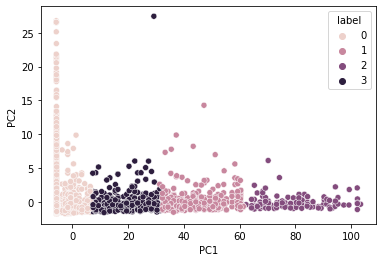

In [37]:
import seaborn as sns
# PCA
pca=PCA()
df_proj=pd.DataFrame(pca.fit_transform(df_processed),columns=[f'PC{i}' for i in range(1, len(num_robust)+len(num_minmax)+len(cat_ord)+1)])
df_proj


df_proj['label']=MiniBatchKMeans(n_clusters=4).fit_predict(df_processed)
sns.scatterplot(df_proj.PC1,df_proj.PC2,hue=df_proj.label)

In [ ]:
# get the weights
# Access our PCs 
v0_W = pca.components_

# Print PCs as COLUMNS
v0_W = pd.DataFrame(v0_W.T,
                 index=num_robust+num_minmax+cat_ord,
                 columns=[f'PC{i}' for i in range(1, len(num_robust)+len(num_minmax)+len(cat_ord)+1)])

#v0_W.style.applymap(lambda x: "background-color: yellow" if abs(x)>0.01 else "background-color: white")
v0_W

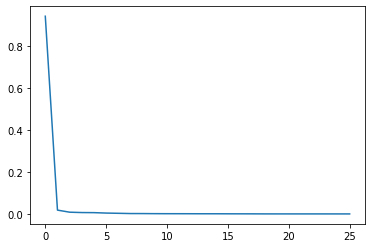

In [32]:
plt.plot(pca.explained_variance_ratio_)

# Model Grid

-- TSNE

-- Other sklearn dimension reduction

## TSNE

In [11]:
import pandas as pd
from sklearn.manifold import TSNE
from customerclustering.trainer_v0 import *
# load the data
df=pd.read_csv('../raw_data/training_data.csv',index_col=[0])

df=clean_data(df)
preproc=Trainer(df,'model_v1',run_pca=False).preprocessing()
df_processed=preproc.fit_transform(df)

#get column names after preprocessing
col_names=preproc.get_feature_names_out().tolist()
col_names=[col[12:] for col in col_names]
tsne=TSNE(perplexity=100)
df_processed=pd.DataFrame(tsne.fit_transform(df_processed),columns=["comp1","comp2"])
df_processed


/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have a high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('be generally complex','generally complex',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the cavea

,comp1,comp2
0,19.194403,21.466396
1,19.198725,21.461069
2,-1.923100,-48.414783
3,4.658902,-46.661972
4,19.225830,21.344881
...,...,...
7123,17.436573,-2.234298
7124,-2.502768,24.011820
7125,-13.798100,10.011593
7126,-0.161689,-4.830712


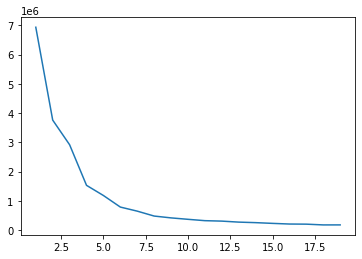

In [14]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
# Apply the elbow method to find the optimal number of clusters.
wcss = []
clusters = list(range(1, 20))
# YOUR CODE HERE
for k in clusters:
    err=MiniBatchKMeans(n_clusters=k).fit(df_processed).inertia_
    wcss.append(err)
    
# YOUR CODE HERE
plt.plot(clusters,wcss); # same as with pca!!!

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='comp1', ylabel='comp2'>

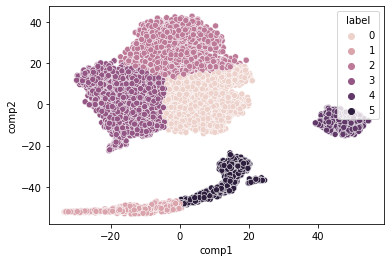

In [16]:
import seaborn as sns
df_proj=df_processed

miniKmeans=MiniBatchKMeans(n_clusters=6)
df_proj['label']=miniKmeans.fit_predict(df_processed)
sns.scatterplot(df_proj.comp1,df_proj.comp2,hue=df_proj.label)

In [26]:
# save the data
#df_proj.to_csv('../raw_data/visaulisation_tsne.csv')
df_labeled=df # it is cleaned
df_labeled['label']=df_proj['label']
#df_labeled.to_csv('../raw_data/withlabel_tsne.csv')
df=clean_data(df)
#preproc=Trainer(df,'model_v1',run_pca=False).preprocessing()
df_processed=preproc.fit_transform(df)
df_processed=pd.DataFrame(df_processed,columns=preproc.get_feature_names_out())
df_processed['label']=df_proj['label']
df_processed.to_csv('../raw_data/withlabel_scaled_tsne.csv')

/var/folders/bh/j223y_td6s35mkxwj_m8bxdm0000gn/T/ipykernel_40461/2743460875.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labeled['label']=df_proj['label']
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.complex.replace('have a high complexity','high complexity',inplace=True)
/Users/yayahuo/code/Ricotta-md/customerclustering/customerclustering/trainer_v0.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the 

In [33]:
df_summary=df_processed[:-1].describe().T.sort_values(by='std',ascending=False)
df_summary

,count,mean,std,min,25%,50%,75%,max
pipeline-1__minCompletedFromQueue,6116.0,4.938522,14.540399,0.000000,0.000000,0.000000,0.000000,91.000000
pipeline-1__minPerYear,6116.0,0.556928,1.546748,-0.693642,-0.317919,0.000000,0.682081,10.739884
label,6116.0,2.218280,1.545473,0.000000,1.000000,2.000000,3.000000,5.000000
pipeline-1__GoalsPerYear,6116.0,0.785971,1.237863,0.000000,0.000000,0.000000,1.000000,6.250000
pipeline-3__access,6116.0,-0.852518,1.226244,-4.000000,-1.000000,0.000000,0.000000,0.000000
pipeline-3__complex,6116.0,0.155657,1.034943,-2.000000,0.000000,0.000000,1.000000,2.000000
pipeline-3__autonomy,6116.0,-0.058535,0.856608,-2.000000,0.000000,0.000000,0.000000,1.000000
pipeline-1__numQueued,6116.0,0.282801,0.807352,-0.500000,-0.333333,0.000000,0.666667,3.444444
pipeline-1__minQueued,6116.0,0.276251,0.796154,-0.475751,-0.338626,-0.000577,0.660797,3.361432
pipeline-1__doc_in_activation,6116.0,0.290876,0.771951,-0.333333,-0.333333,0.000000,0.666667,7.666667


In [49]:
from customerclustering.encoder import customTSNE
myTSNE=customTSNE(perplexity=30)
myTSNE.fit_transform(df[df.describe().columns].dropna())


/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,num_subs,account_age,hasPracticeRecord,docPerYear,docOnAusmedPerYear,minPerYear,minOnAusmedPerYear,learnFromAusmedRatio_num,learnFromAusmedRatio_min,numQueued,...,minQueued,minCompletedFromQueue,RatioOfCompletion_num,RatioOfCompletion_min,event_cpd_day_diff,doc_in_activation,activated,subscribe_days,GoalsPerYear,ratioOfAchivedGoals
0,10,1620.0,1,2.500000,2.250000,385.000000,77.500000,0.90,0.201299,8,...,442.0,0.0,0.000000,0.000000,117.197044,10,1,1552,5.0,0.4
1,9,1240.0,1,2.000000,2.000000,56.000000,56.000000,1.00,1.000000,4,...,228.0,0.0,0.000000,0.000000,164.064103,2,1,0,1.5,0.0
2,6,2129.0,1,1.333333,0.333333,88.333333,20.000000,0.25,0.226415,9,...,492.0,35.0,0.111111,0.071138,149.362205,4,1,193,2.0,0.0
3,5,1952.0,1,1.000000,1.000000,26.000000,26.000000,1.00,1.000000,46,...,1909.0,25.0,0.043478,0.013096,76.311787,2,1,322,1.0,0.0
4,5,1190.0,1,2.000000,2.000000,121.000000,121.000000,1.00,1.000000,22,...,1256.0,0.0,0.000000,0.000000,8.618321,4,1,80,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7477,1,1147.0,1,1.500000,1.500000,18.500000,18.500000,1.00,1.000000,16,...,777.0,0.0,0.000000,0.000000,133.187500,3,1,612,1.0,0.0
7478,1,1900.0,1,1.333333,0.000000,63.333333,0.000000,0.00,0.000000,5,...,260.0,0.0,0.000000,0.000000,122.828571,4,1,6,1.0,0.0
7479,1,1882.0,1,1.000000,1.000000,630.000000,630.000000,1.00,1.000000,11,...,681.0,0.0,0.000000,0.000000,157.558824,1,0,1032,1.0,0.0
7480,1,1750.0,1,1.333333,0.333333,76.666667,1.666667,0.25,0.021739,4,...,106.0,0.0,0.000000,0.000000,127.921053,4,1,92,3.0,0.0


In [109]:
miniKmeans.cluster_centers_

array([[ -8.33481194,  61.27953407,   6.38681948],
       [  0.62567356,   8.02027863,   4.01080285],
       [-49.16453402,  -1.25740803,   1.32752319],
       [ 59.44988196,   1.87768514,   2.61292589],
       [  7.39370833, -38.04386806,   4.84080776]])

## Interesting Exploration

array(['e-Learning'], dtype=object)

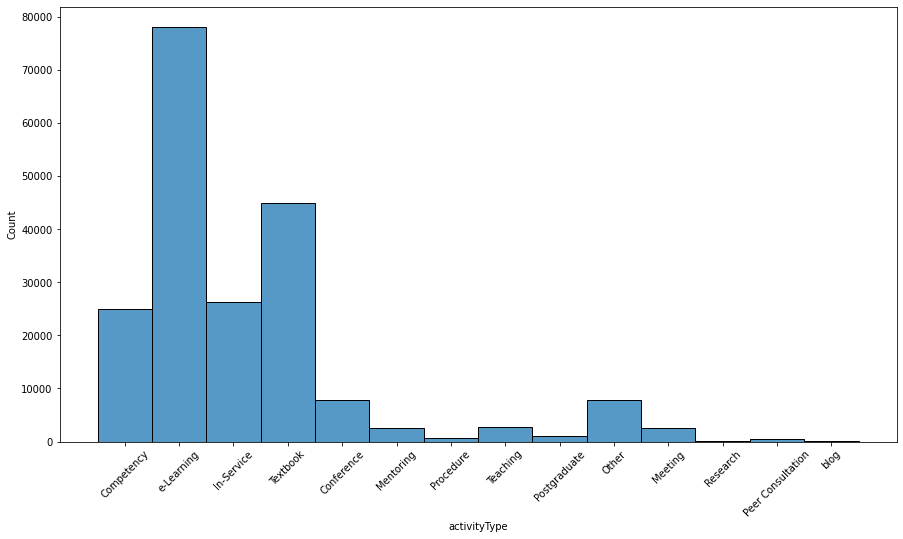

In [22]:
# exploring the distribution of activityType
import matplotlib.pyplot as plt
import seaborn as sns
df_act=df_act_copy
plt.figure(figsize = (15,8))
ax =sns.histplot(df_act['activityType'])
plt.xticks(rotation=45)



In [43]:
cat_col=[col for col in df.columns if col not in df.describe().columns]
df[cat_col].nunique()

Product                     8
Status                      5
userID                   7482
stripeCustID             7482
pProfileID               7482
typeOfPractice            474
located                     7
specialities             3667
population                473
focus                     444
complex                     8
autonomy                    6
access                      4
country                     7
activityType               12
secondFavActivityType      13
plan_type                   3
metaGoalTitle            7378
dtype: int64

# Redo Queue data

In [96]:
from customerclustering.queued import *
queue=Queue(conn)

/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/Users/yayahuo/.pyenv/versions/3.8.13/envs/customerclustering/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [97]:
df_que=queue.get_event_data()
df_que

,eventID,userID,resourceID,eventType,source,eventYear,resourceType,action,isQueued,isCompleted,CompletedFromQueue,min,minQueued,minCompletedFromQueue
0,376d6bc2-1637-4c41-b38d-903a4c0d0d0b,00001d9c-5de5-4ed2-9ecc-98341286765a,3a354eb7-6611-4eab-90a4-d83c5e47e3b2,blog_clicked,ausmed,2019,blog,clicked,0,0,0,2.0,0.0,0.0
1,e2ba9e3e-27bb-429e-b8fa-c619f5f702ac,00001d9c-5de5-4ed2-9ecc-98341286765a,3a354eb7-6611-4eab-90a4-d83c5e47e3b2,blog_documented,ausmed,2020,blog,documented,0,1,0,2.0,0.0,0.0
2,a0e53ee5-c235-40ff-9e33-13f50ac12ba1,003c59f9-a520-4c3b-8c77-792b71325ad4,3a354eb7-6611-4eab-90a4-d83c5e47e3b2,blog_clicked,ausmed,2019,blog,clicked,0,0,0,2.0,0.0,0.0
3,fea50cf4-47f6-4fda-839f-e41a6d757447,003c59f9-a520-4c3b-8c77-792b71325ad4,3a354eb7-6611-4eab-90a4-d83c5e47e3b2,blog_dismissed,ausmed,2022,blog,dismissed,0,0,0,2.0,0.0,0.0
4,c7678785-fbb3-4f64-9be8-76b234d57886,01d38a79-6160-4d97-a4fe-933db8c23c5e,3a354eb7-6611-4eab-90a4-d83c5e47e3b2,blog_clicked,ausmed,2019,blog,clicked,0,0,0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2694772,20059a50-7bca-4154-a441-2844a365738a,f8d53b6d-5eaa-4171-949d-edff7918644d,0f44bcc3-cbef-46e9-b2f5-09d8630b2aec,lecture_completed,ausmed,2017,lecture,completed,0,1,0,17.0,0.0,0.0
2694773,dc11fc8c-1b3e-4066-a5c8-68a6f1e18141,f8d53b6d-5eaa-4171-949d-edff7918644d,0f44bcc3-cbef-46e9-b2f5-09d8630b2aec,lecture_documented,ausmed,2017,lecture,documented,0,1,0,17.0,0.0,0.0
2694774,bed27f2b-c6e1-4c19-9c0b-18df92b6352a,fc4f6976-0e2b-4fb4-b5e8-9fe8e9bba825,0f44bcc3-cbef-46e9-b2f5-09d8630b2aec,lecture_playing,ausmed,2017,lecture,playing,0,0,0,17.0,0.0,0.0
2694775,cb30648e-eb22-4a0a-b857-72064f003bad,fc4f6976-0e2b-4fb4-b5e8-9fe8e9bba825,0f44bcc3-cbef-46e9-b2f5-09d8630b2aec,lecture_completed,ausmed,2017,lecture,completed,0,1,0,17.0,0.0,0.0


In [101]:
df_que_gr0=df_que.groupby(['userID','eventYear']).sum().reset_index()

In [102]:
df_que_gr0

,userID,eventYear,isQueued,isCompleted,CompletedFromQueue,min,minQueued,minCompletedFromQueue
0,00001d9c-5de5-4ed2-9ecc-98341286765a,2019,0,0,0,2.0,0.0,0.0
1,00001d9c-5de5-4ed2-9ecc-98341286765a,2020,12,8,0,1136.0,700.0,0.0
2,0000c854-c7a3-4047-9a54-2e1a3464621f,2017,0,0,0,5.0,0.0,0.0
3,0000c854-c7a3-4047-9a54-2e1a3464621f,2018,0,2,0,18.0,0.0,0.0
4,0000c854-c7a3-4047-9a54-2e1a3464621f,2020,0,0,0,8.0,0.0,0.0
...,...,...,...,...,...,...,...,...
210448,fffbdf70-3cc6-44aa-bd74-f9f774d2b25c,2020,0,4,0,44.0,0.0,0.0
210449,fffbdf70-3cc6-44aa-bd74-f9f774d2b25c,2021,0,0,0,4.0,0.0,0.0
210450,fffe2cf6-fcf3-425f-aaed-c0a0c07f9292,2020,0,1,0,10.0,0.0,0.0
210451,ffff1bc4-d54f-4c43-926c-0146f22dd26f,2020,0,1,0,17.0,0.0,0.0


In [111]:
df_que_gr1=df_que_gr0.groupby('userID').mean().reset_index()
df_que_gr1.drop(columns=['eventYear'],inplace=True)
df_que_gr1.rename(columns={'isQueued':'numQueuedPerYear','isCompleted':'numCompletedOnelinePerYear',
                           'CompletedFromQueue':'numCompletedFromQueuePerYear',
                           'min':'minCompletedOnelinePerYear',
                           'minQueued':'minQueuedPerYear','minCompletedFromQueue':'minCompletedFromQueuePerYear'},inplace=True)
df_que_gr1


,userID,numQueuedPerYear,numCompletedOnelinePerYear,numCompletedFromQueuePerYear,minCompletedOnelinePerYear,minQueuedPerYear,minCompletedFromQueuePerYear
0,00001d9c-5de5-4ed2-9ecc-98341286765a,6.0,4.000000,0.0,569.000000,350.0,0.0
1,0000c854-c7a3-4047-9a54-2e1a3464621f,0.0,0.666667,0.0,10.333333,0.0,0.0
2,000169ca-f6bf-4ac0-a13d-c2b188014962,0.0,0.000000,0.0,4.000000,0.0,0.0
3,0001c897-b1fe-40e0-afef-6a667edf41f7,0.0,0.500000,0.0,17.000000,0.0,0.0
4,0002e8b5-261b-44a6-b38c-2997b4007317,0.0,12.000000,0.0,679.000000,0.0,0.0
...,...,...,...,...,...,...,...
141103,fffb44bb-83ee-48aa-9e48-3222cb8d6fe2,0.0,0.000000,0.0,2.000000,0.0,0.0
141104,fffbdf70-3cc6-44aa-bd74-f9f774d2b25c,0.0,2.000000,0.0,24.000000,0.0,0.0
141105,fffe2cf6-fcf3-425f-aaed-c0a0c07f9292,0.0,1.000000,0.0,10.000000,0.0,0.0
141106,ffff1bc4-d54f-4c43-926c-0146f22dd26f,0.0,1.000000,0.0,17.000000,0.0,0.0


In [104]:
df_que_gr1.describe()

,eventYear,isQueued,isCompleted,CompletedFromQueue,min,minQueued,minCompletedFromQueue
count,141108.000000,141108.000000,141108.000000,141108.0,141108.000000,141108.000000,141108.0
mean,2020.256085,1.726711,4.575163,0.0,302.776826,77.597716,0.0
std,0.955808,5.389002,9.082214,0.0,679.324251,235.849724,0.0
min,2017.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,2020.000000,0.000000,0.500000,0.0,8.000000,0.000000,0.0
50%,2020.500000,0.000000,1.000000,0.0,40.000000,0.000000,0.0
75%,2021.000000,1.000000,4.250000,0.0,260.000000,42.000000,0.0
max,2022.000000,506.000000,320.000000,0.0,14508.000000,11605.000000,0.0
